# Cardamom Price: Regime Changes & Historical Analysis

Looking back at 11 years of auction data to identify:
- **Regime change points** — when price behaviour fundamentally shifted
- **Best and worst years** for cardamom prices
- **Why** — cross-referencing with weather, macro, and demand data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import FancyArrowPatch
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (16, 5)
plt.rcParams['figure.dpi'] = 100

# === Load all data ===
df = pd.read_html('Small Cardamom Auction Prices.xls', header=0)[0]
df = df[df.iloc[:, 0] != 'Date of Auction'].reset_index(drop=True)
df.columns = ['Date', 'Auctioneer', 'Lots', 'Qty_Arrived_Kg', 'Qty_Sold_Kg', 'MaxPrice', 'AvgPrice']
df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=False)
for col in ['Lots', 'Qty_Arrived_Kg', 'Qty_Sold_Kg', 'MaxPrice', 'AvgPrice']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna(subset=['Date']).reset_index(drop=True)

# Daily aggregation
daily = df.groupby('Date').agg(
    Total_Lots=('Lots', 'sum'),
    Total_Arrived=('Qty_Arrived_Kg', 'sum'),
    Total_Sold=('Qty_Sold_Kg', 'sum'),
    MaxPrice=('MaxPrice', 'max'),
    AvgPrice=('AvgPrice', lambda x: np.average(x, weights=df.loc[x.index, 'Qty_Sold_Kg'].clip(lower=1))),
    Num_Auctions=('Auctioneer', 'nunique')
).reset_index()
daily = daily.sort_values('Date').reset_index(drop=True)
daily = daily[daily['AvgPrice'] > 0].reset_index(drop=True)

# External data
def load_yf(path, name):
    raw = pd.read_csv(path, header=None, skiprows=3)
    raw.columns = ['Date','Close','High','Low','Open','Volume']
    raw['Date'] = pd.to_datetime(raw['Date'])
    raw = raw[['Date','Close']].rename(columns={'Close': name})
    raw[name] = pd.to_numeric(raw[name], errors='coerce')
    return raw.dropna()

weather = pd.read_csv('external_idukki_weather.csv', parse_dates=['Date'])
gt_weather = pd.read_csv('external_guatemala_weather.csv', parse_dates=['Date'])
usdinr = load_yf('external_usdinr.csv', 'USDINR')
oil = load_yf('external_crude_oil.csv', 'CrudeOil')

oni_raw = pd.read_csv('external_enso_oni.csv')
stm = {'DJF':1,'JFM':2,'FMA':3,'MAM':4,'AMJ':5,'MJJ':6,'JJA':7,'JAS':8,'ASO':9,'SON':10,'OND':11,'NDJ':12}
oni_raw['month'] = oni_raw['SEAS'].map(stm)
oni_raw['Date'] = pd.to_datetime(oni_raw['YR'].astype(str)+'-'+oni_raw['month'].astype(str)+'-15')
oni = oni_raw[['Date','ANOM']].rename(columns={'ANOM':'ENSO'})
oni = oni.set_index('Date').resample('D').ffill().reset_index()

# Merge onto daily
m = daily.merge(weather, on='Date', how='left')
m = m.merge(gt_weather, on='Date', how='left')
for ext, name in [(usdinr,'USDINR'),(oil,'CrudeOil')]:
    ext = ext.sort_values('Date').drop_duplicates('Date')
    m = m.merge(ext, on='Date', how='left')
    m[name] = m[name].ffill()
m = m.merge(oni, on='Date', how='left')
m['ENSO'] = m['ENSO'].ffill()
m = m.ffill().bfill().dropna().reset_index(drop=True)

# Weekly & Monthly
mi = m.set_index('Date')
monthly = mi['AvgPrice'].resample('M').mean().to_frame('AvgPrice')
monthly['rain_mm'] = mi['rain_mm'].resample('M').sum()
monthly['gt_rain_mm'] = mi['gt_rain_mm'].resample('M').sum()
monthly['USDINR'] = mi['USDINR'].resample('M').last()
monthly['CrudeOil'] = mi['CrudeOil'].resample('M').last()
monthly['ENSO'] = mi['ENSO'].resample('M').last()
monthly['Total_Sold'] = mi['Total_Sold'].resample('M').sum()
monthly['Total_Arrived'] = mi['Total_Arrived'].resample('M').sum()
monthly['temp_max'] = mi['temp_max_c'].resample('M').mean()
monthly['humidity'] = mi['humidity_pct'].resample('M').mean()
monthly = monthly.reset_index()

print(f'Daily: {len(m)} rows | Monthly: {len(monthly)} rows')
print(f'Period: {m["Date"].min().date()} to {m["Date"].max().date()}')

Daily: 3028 rows | Monthly: 136 rows
Period: 2014-11-07 to 2026-02-06


## 1. The Full Price History — Annotated

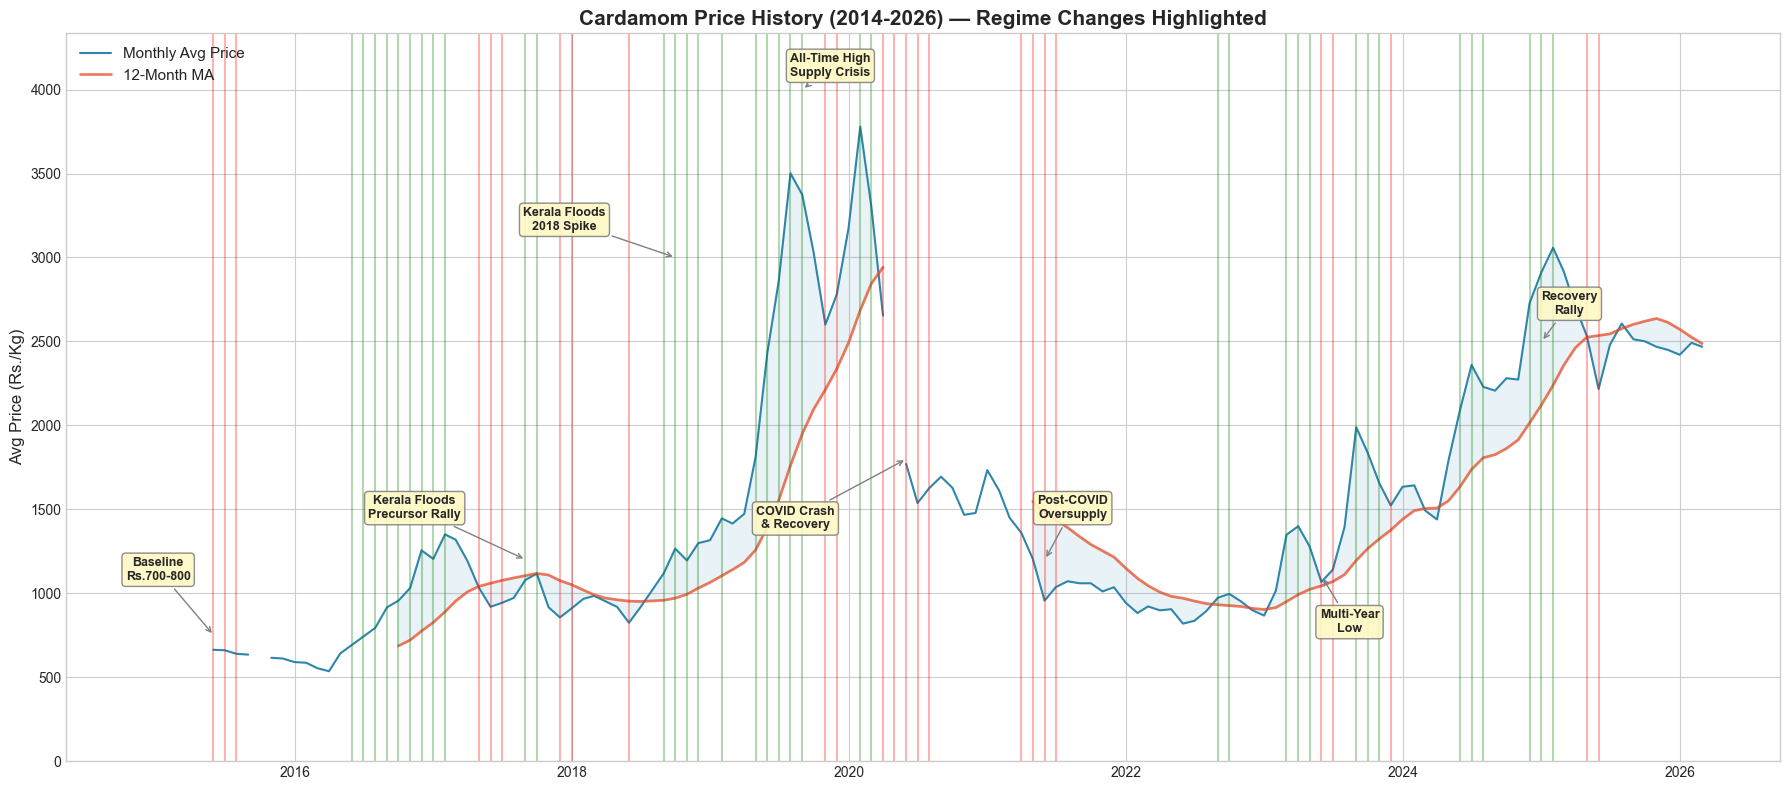

In [2]:
# Compute regime change metrics
monthly['ma_12m'] = monthly['AvgPrice'].rolling(12).mean()
monthly['ma_3m'] = monthly['AvgPrice'].rolling(3).mean()
monthly['volatility_6m'] = monthly['AvgPrice'].rolling(6).std()
monthly['pct_change_3m'] = monthly['AvgPrice'].pct_change(3) * 100
monthly['pct_change_6m'] = monthly['AvgPrice'].pct_change(6) * 100

# Detect regime changes: large 3-month moves (>15% or <-15%)
monthly['regime_shift'] = (monthly['pct_change_3m'].abs() > 15)

fig, ax = plt.subplots(figsize=(18, 8))

# Price
ax.plot(monthly['Date'], monthly['AvgPrice'], color='#2E86AB', linewidth=1.5, label='Monthly Avg Price')
ax.plot(monthly['Date'], monthly['ma_12m'], color='#E8451E', linewidth=2, alpha=0.7, label='12-Month MA')
ax.fill_between(monthly['Date'], monthly['AvgPrice'], monthly['ma_12m'], alpha=0.1, color='#2E86AB')

# Mark regime shifts
shifts = monthly[monthly['regime_shift']]
for _, row in shifts.iterrows():
    color = 'green' if row['pct_change_3m'] > 0 else 'red'
    ax.axvline(row['Date'], color=color, alpha=0.3, linewidth=1.5)

# Annotate key periods
annotations = [
    ('2015-06-01', 750, 'Baseline\nRs.700-800', -40, 40),
    ('2017-09-01', 1200, 'Kerala Floods\nPrecursor Rally', -80, 30),
    ('2018-10-01', 3000, 'Kerala Floods\n2018 Spike', -80, 20),
    ('2019-09-01', 4000, 'All-Time High\nSupply Crisis', 20, 10),
    ('2020-06-01', 1800, 'COVID Crash\n& Recovery', -80, -50),
    ('2021-06-01', 1200, 'Post-COVID\nOversupply', 20, 30),
    ('2023-06-01', 1100, 'Multi-Year\nLow', 20, -40),
    ('2025-01-01', 2500, 'Recovery\nRally', 20, 20),
]

for date_str, price, label, xoff, yoff in annotations:
    ax.annotate(label, xy=(pd.to_datetime(date_str), price),
                xytext=(xoff, yoff), textcoords='offset points',
                fontsize=9, fontweight='bold', ha='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='#FFF9C4', edgecolor='gray', alpha=0.9),
                arrowprops=dict(arrowstyle='->', color='gray', lw=1))

ax.set_title('Cardamom Price History (2014-2026) — Regime Changes Highlighted', fontsize=15, fontweight='bold')
ax.set_ylabel('Avg Price (Rs./Kg)', fontsize=12)
ax.legend(fontsize=11, loc='upper left')
ax.set_ylim(0, ax.get_ylim()[1] * 1.1)
plt.tight_layout()
plt.show()

## 2. Regime Change Detection — Structural Breaks

In [3]:
# Identify the major regime change points using rolling statistics
# A regime change = sustained shift in price LEVEL (not just a spike)

# Use 6-month rolling mean crossover with 12-month rolling mean
monthly['ma_6m'] = monthly['AvgPrice'].rolling(6).mean()
monthly['trend_signal'] = np.where(monthly['ma_3m'] > monthly['ma_12m'], 1, -1)
monthly['signal_change'] = monthly['trend_signal'].diff().abs() > 0

crossovers = monthly[monthly['signal_change']].copy()
crossovers['direction'] = np.where(crossovers['trend_signal'] == 1, 'BULLISH', 'BEARISH')

print('Major Trend Reversals (3M MA crosses 12M MA):')
print(f'{"Date":<14} {"Direction":<12} {"Price":>10} {"12M MA":>10} {"3M Change":>12}')
print('-' * 60)
for _, row in crossovers.dropna(subset=['ma_12m']).iterrows():
    print(f'{row["Date"].strftime("%b %Y"):<14} {row["direction"]:<12} '
          f'Rs.{row["AvgPrice"]:>7.0f} Rs.{row["ma_12m"]:>7.0f} {row["pct_change_3m"]:>+10.1f}%')

Major Trend Reversals (3M MA crosses 12M MA):
Date           Direction         Price     12M MA    3M Change
------------------------------------------------------------
Sep 2016       BULLISH      Rs.    956 Rs.    686      +28.7%
May 2017       BEARISH      Rs.    919 Rs.   1060      -30.3%
Aug 2018       BULLISH      Rs.   1120 Rs.    958      +35.8%
Sep 2022       BULLISH      Rs.    996 Rs.    926      +19.2%
May 2025       BEARISH      Rs.   2217 Rs.   2535      -24.0%


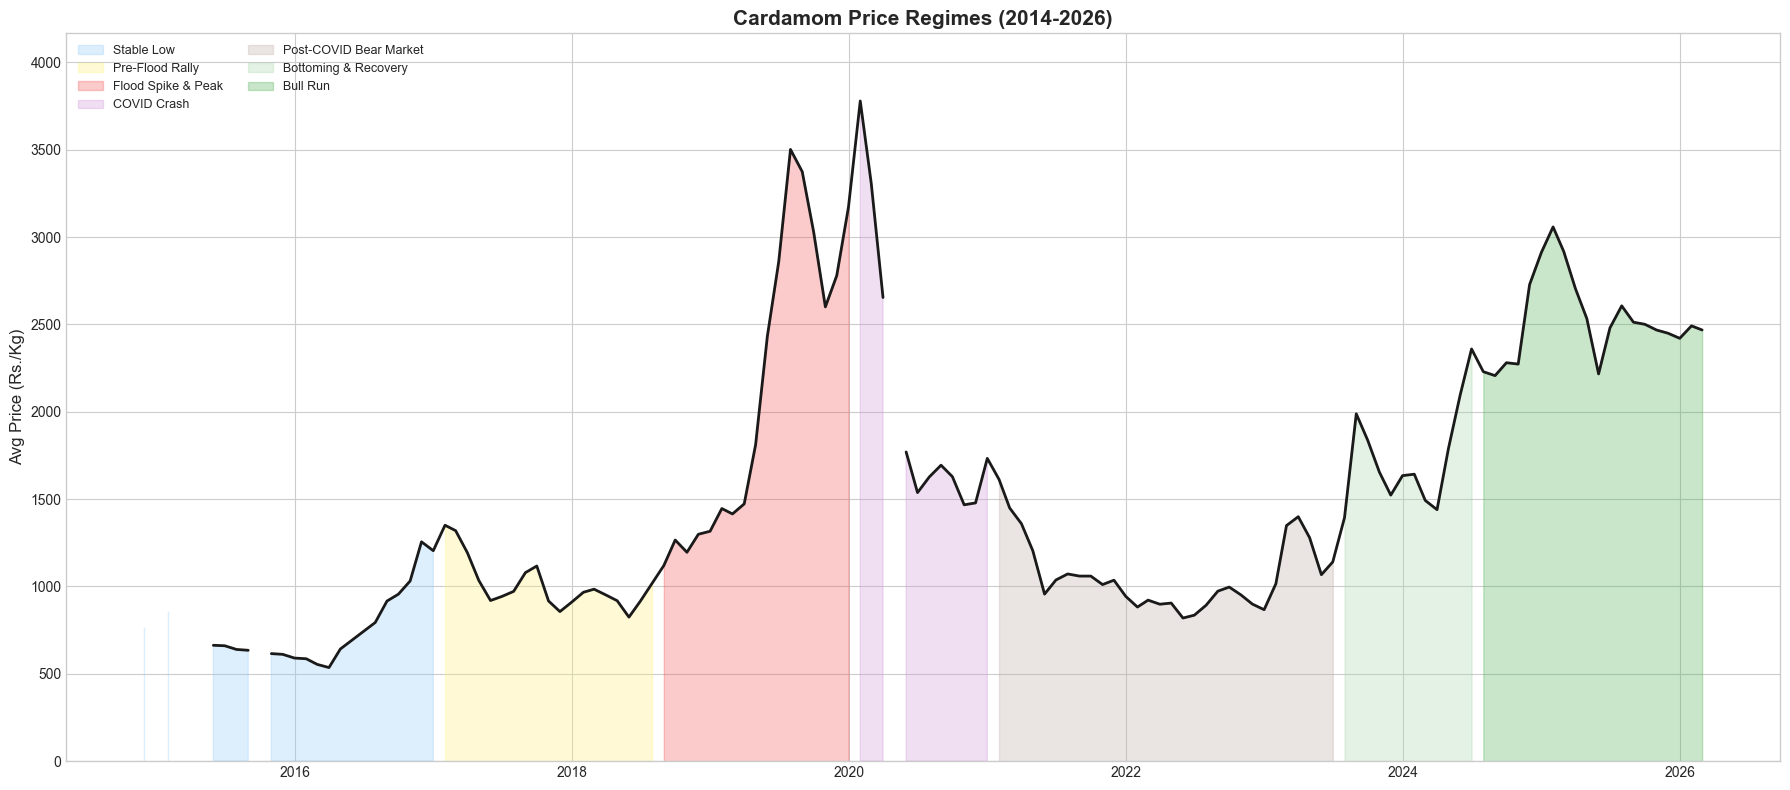


REGIME DESCRIPTIONS

Stable Low (2014-11 to 2016-12)
  Price range: Rs.536 - Rs.1256 (avg Rs.760)
  Post-2013 correction. Prices stable at Rs.700-900. Good harvests, adequate supply.

Pre-Flood Rally (2017-01 to 2018-07)
  Price range: Rs.824 - Rs.1351 (avg Rs.1010)
  Gradual rise from Rs.900 to Rs.1,400. Growing demand, normal supply tightening.

Flood Spike & Peak (2018-08 to 2019-12)
  Price range: Rs.1120 - Rs.3502 (avg Rs.2123)
  Kerala floods (Aug 2018) devastated crops. Supply shock drove prices from Rs.1,400 to Rs.4,000+. All-time highs.

COVID Crash (2020-01 to 2020-12)
  Price range: Rs.1467 - Rs.3779 (avg Rs.2061)
  Pandemic crushed demand. Export markets shut. Prices fell from Rs.3,000 to Rs.1,500. Auctions disrupted.

Post-COVID Bear Market (2021-01 to 2023-06)
  Price range: Rs.819 - Rs.1613 (avg Rs.1063)
  Oversupply from recovery plantings + weak export demand. Long decline to Rs.900-1,100. Farmers distressed.

Bottoming & Recovery (2023-07 to 2024-06)
  Price range: R

In [4]:
# Define the major regimes manually based on the data
regimes = [
    ('2014-11-01', '2016-12-31', 'Stable Low', '#90CAF9', 
     'Post-2013 correction. Prices stable at Rs.700-900. Good harvests, adequate supply.'),
    ('2017-01-01', '2018-07-31', 'Pre-Flood Rally', '#FFF176',
     'Gradual rise from Rs.900 to Rs.1,400. Growing demand, normal supply tightening.'),
    ('2018-08-01', '2019-12-31', 'Flood Spike & Peak', '#EF5350',
     'Kerala floods (Aug 2018) devastated crops. Supply shock drove prices from Rs.1,400 to Rs.4,000+. All-time highs.'),
    ('2020-01-01', '2020-12-31', 'COVID Crash', '#CE93D8',
     'Pandemic crushed demand. Export markets shut. Prices fell from Rs.3,000 to Rs.1,500. Auctions disrupted.'),
    ('2021-01-01', '2023-06-30', 'Post-COVID Bear Market', '#BCAAA4',
     'Oversupply from recovery plantings + weak export demand. Long decline to Rs.900-1,100. Farmers distressed.'),
    ('2023-07-01', '2024-06-30', 'Bottoming & Recovery', '#A5D6A7',
     'Prices bottomed near Rs.1,000. New demand from Middle East pre-Eid buying. Gradual recovery begins.'),
    ('2024-07-01', '2026-02-28', 'Bull Run', '#4CAF50',
     'Sharp rally from Rs.1,500 to Rs.2,500+. Tight supply from poor monsoon + strong export demand.'),
]

fig, ax = plt.subplots(figsize=(18, 8))

for start, end, label, color, _ in regimes:
    mask = (monthly['Date'] >= start) & (monthly['Date'] <= end)
    subset = monthly[mask]
    ax.fill_between(subset['Date'], 0, subset['AvgPrice'], alpha=0.3, color=color, label=label)

ax.plot(monthly['Date'], monthly['AvgPrice'], color='#1a1a1a', linewidth=2)
ax.set_title('Cardamom Price Regimes (2014-2026)', fontsize=15, fontweight='bold')
ax.set_ylabel('Avg Price (Rs./Kg)', fontsize=12)
ax.legend(loc='upper left', fontsize=9, ncol=2)
ax.set_ylim(0, ax.get_ylim()[1] * 1.05)
plt.tight_layout()
plt.show()

# Print regime descriptions
print('\n' + '='*90)
print('REGIME DESCRIPTIONS')
print('='*90)
for start, end, label, _, desc in regimes:
    mask = (monthly['Date'] >= start) & (monthly['Date'] <= end)
    subset = monthly[mask]
    if len(subset) > 0:
        avg = subset['AvgPrice'].mean()
        lo = subset['AvgPrice'].min()
        hi = subset['AvgPrice'].max()
        print(f'\n{label} ({start[:7]} to {end[:7]})')
        print(f'  Price range: Rs.{lo:.0f} - Rs.{hi:.0f} (avg Rs.{avg:.0f})')
        print(f'  {desc}')

## 3. What Caused Each Regime Change?

Cross-referencing price moves with external data.

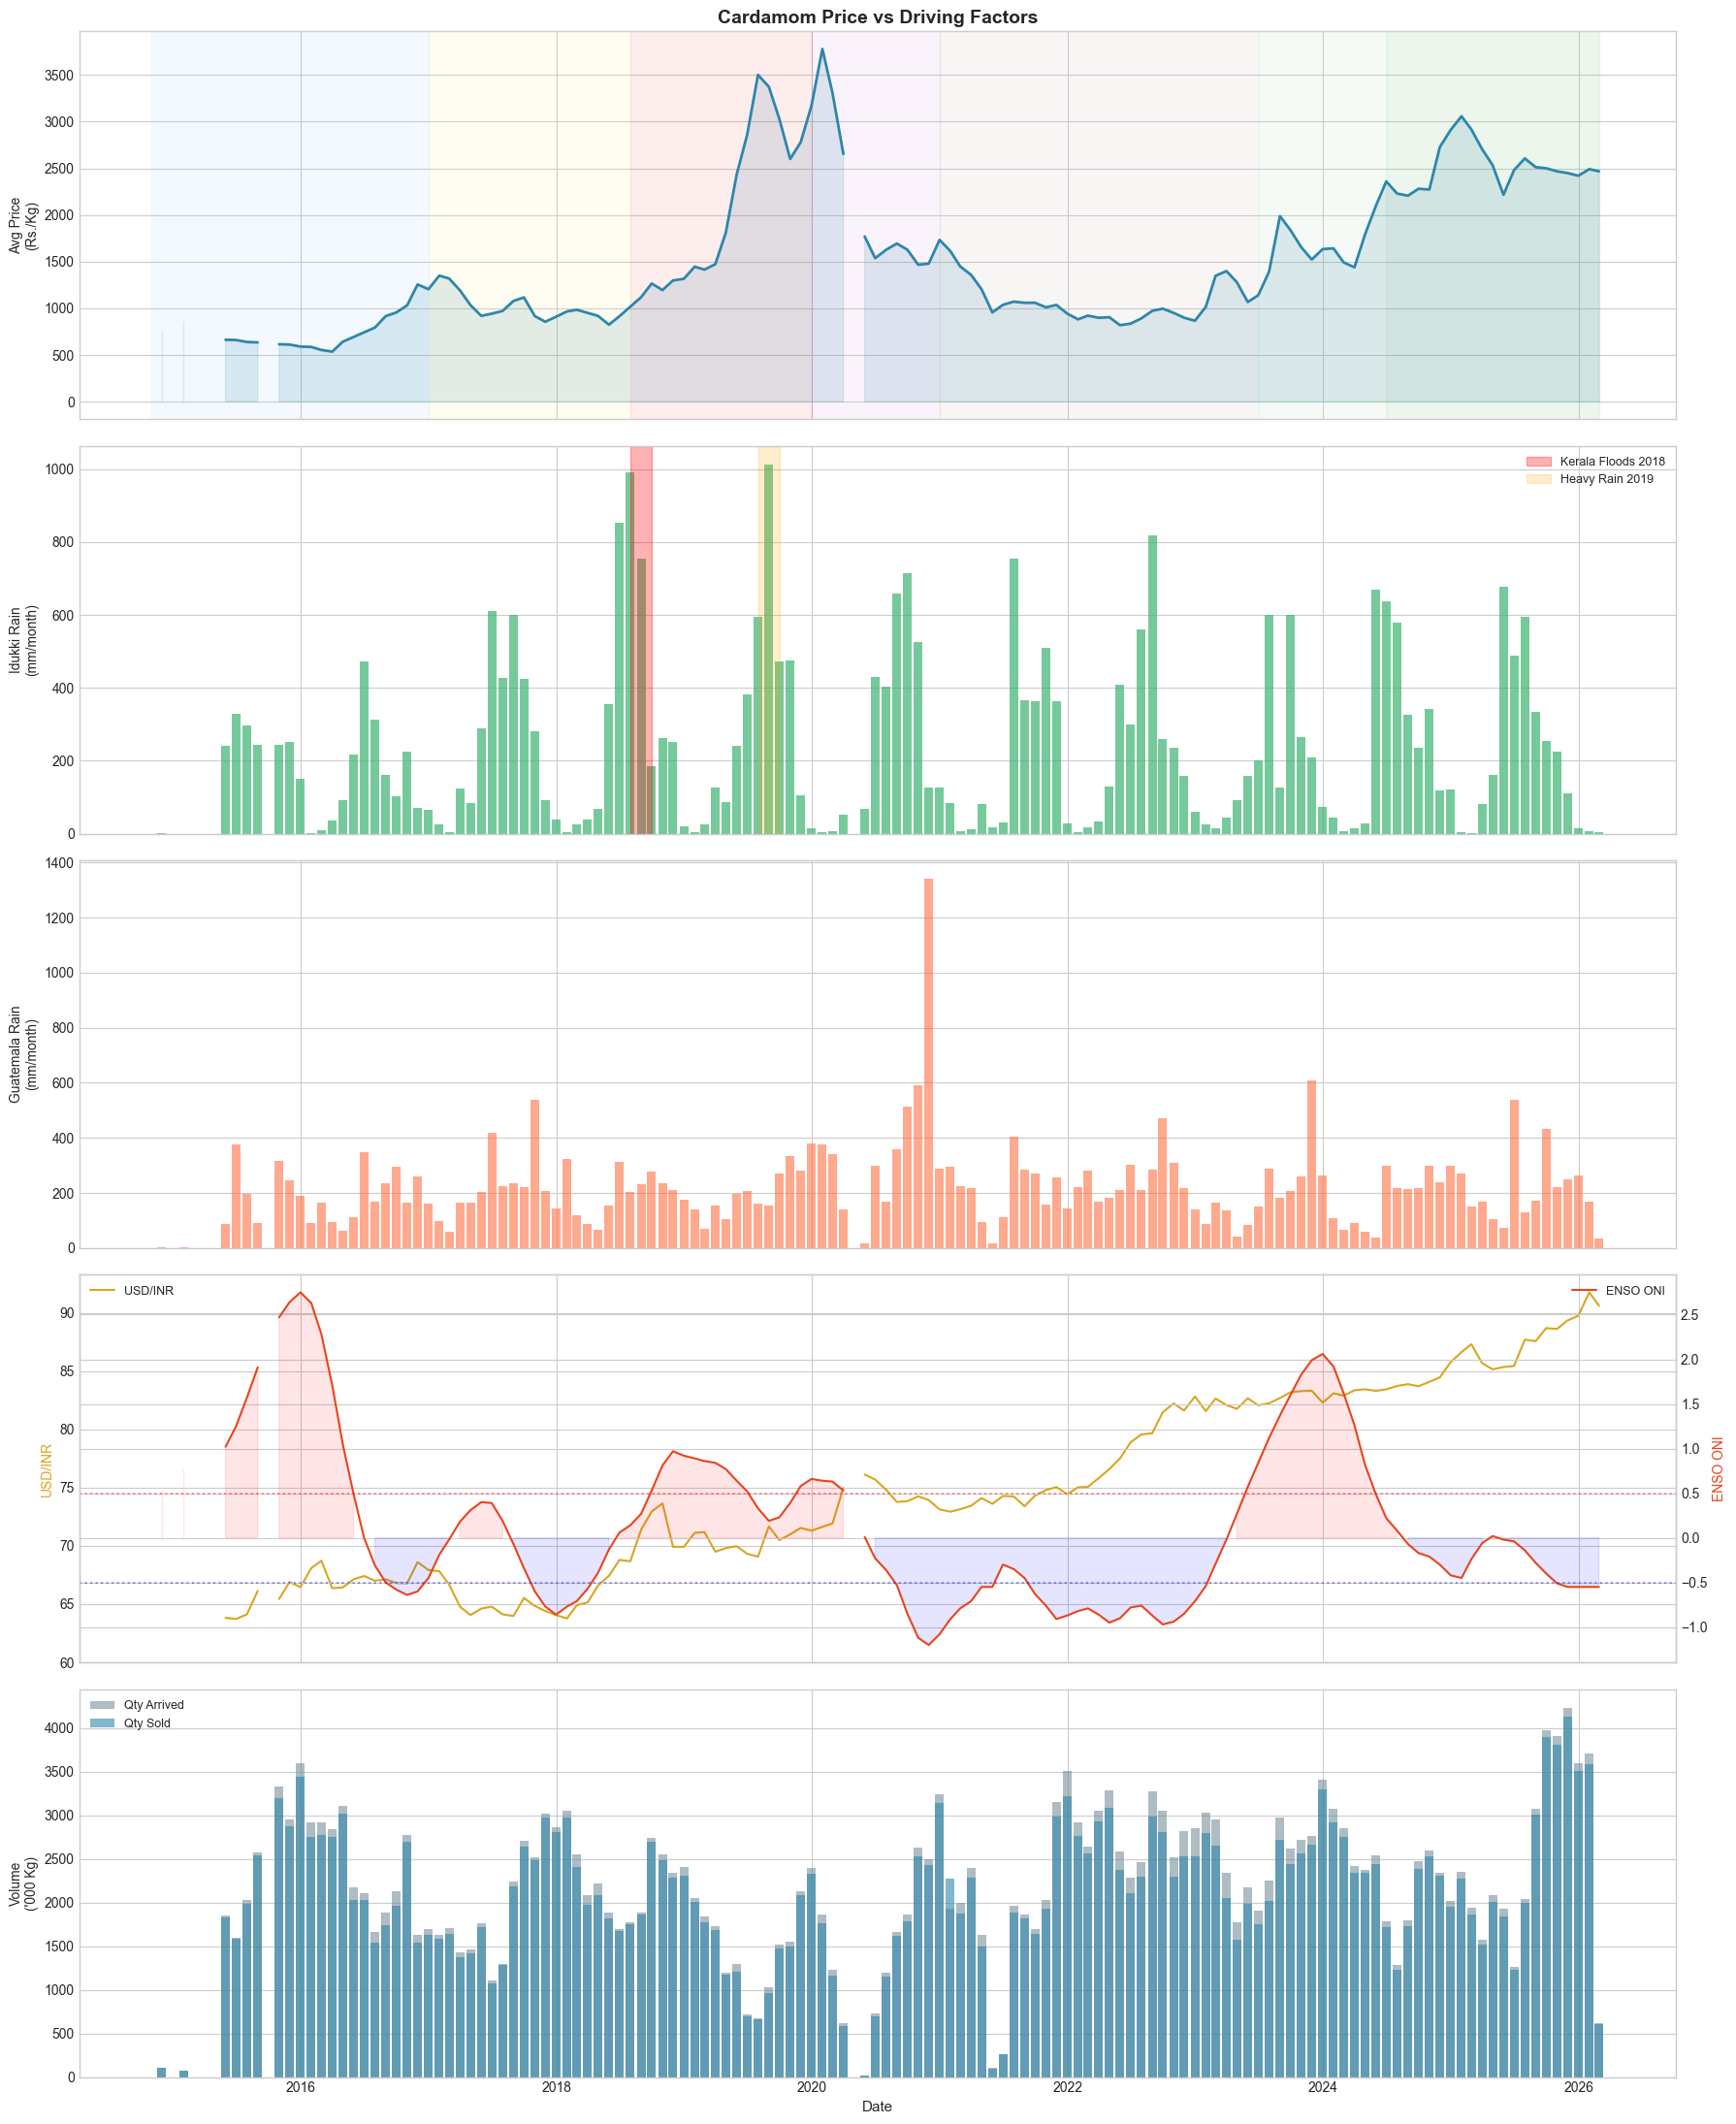

In [5]:
# Multi-panel chart: Price + Weather + Macro + Volume
fig, axes = plt.subplots(5, 1, figsize=(18, 22), sharex=True)

# 1. PRICE
ax = axes[0]
ax.plot(monthly['Date'], monthly['AvgPrice'], color='#2E86AB', linewidth=2)
ax.fill_between(monthly['Date'], monthly['AvgPrice'], alpha=0.15, color='#2E86AB')
ax.set_ylabel('Avg Price\n(Rs./Kg)', fontsize=10)
ax.set_title('Cardamom Price vs Driving Factors', fontsize=14, fontweight='bold')
# Shade regime periods
for start, end, label, color, _ in regimes:
    ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), alpha=0.1, color=color)

# 2. IDUKKI RAINFALL
ax = axes[1]
ax.bar(monthly['Date'], monthly['rain_mm'], width=25, color='#3CB371', alpha=0.7)
ax.set_ylabel('Idukki Rain\n(mm/month)', fontsize=10)
# Mark Kerala floods
ax.axvspan('2018-08-01', '2018-09-30', alpha=0.3, color='red', label='Kerala Floods 2018')
ax.axvspan('2019-08-01', '2019-09-30', alpha=0.2, color='orange', label='Heavy Rain 2019')
ax.legend(fontsize=9)

# 3. GUATEMALA RAINFALL (competing supply)
ax = axes[2]
ax.bar(monthly['Date'], monthly['gt_rain_mm'], width=25, color='#FF7043', alpha=0.6)
ax.set_ylabel('Guatemala Rain\n(mm/month)', fontsize=10)

# 4. MACRO: USD/INR + ENSO
ax = axes[3]
ax.plot(monthly['Date'], monthly['USDINR'], color='#DAA520', linewidth=1.5, label='USD/INR')
ax.set_ylabel('USD/INR', fontsize=10, color='#DAA520')
ax2 = ax.twinx()
ax2.plot(monthly['Date'], monthly['ENSO'], color='#E8451E', linewidth=1.5, label='ENSO ONI')
ax2.axhline(0.5, color='red', linestyle=':', alpha=0.4)
ax2.axhline(-0.5, color='blue', linestyle=':', alpha=0.4)
ax2.fill_between(monthly['Date'], monthly['ENSO'], 0, where=monthly['ENSO']>0, alpha=0.1, color='red')
ax2.fill_between(monthly['Date'], monthly['ENSO'], 0, where=monthly['ENSO']<0, alpha=0.1, color='blue')
ax2.set_ylabel('ENSO ONI', fontsize=10, color='#E8451E')
ax.legend(loc='upper left', fontsize=9)
ax2.legend(loc='upper right', fontsize=9)

# 5. VOLUME
ax = axes[4]
ax.bar(monthly['Date'], monthly['Total_Arrived']/1000, width=25, color='#78909C', alpha=0.6, label='Qty Arrived')
ax.bar(monthly['Date'], monthly['Total_Sold']/1000, width=25, color='#2E86AB', alpha=0.6, label='Qty Sold')
ax.set_ylabel('Volume\n(\'000 Kg)', fontsize=10)
ax.legend(fontsize=9)
ax.set_xlabel('Date', fontsize=11)

plt.tight_layout()
plt.show()

## 4. Best & Worst Years

In [6]:
# Annual statistics
m['Year'] = m['Date'].dt.year
annual = m.groupby('Year').agg(
    Avg_Price=('AvgPrice', 'mean'),
    Min_Price=('AvgPrice', 'min'),
    Max_Price=('AvgPrice', 'max'),
    Price_Std=('AvgPrice', 'std'),
    Total_Volume_Sold=('Total_Sold', 'sum'),
    Total_Volume_Arrived=('Total_Arrived', 'sum'),
    Avg_Rain_mm=('rain_mm', 'mean'),
    Total_Rain_mm=('rain_mm', 'sum'),
    Avg_USDINR=('USDINR', 'mean'),
    Avg_ENSO=('ENSO', 'mean'),
    Auction_Days=('AvgPrice', 'count')
).reset_index()

# YoY change
annual['YoY_Change'] = annual['Avg_Price'].pct_change() * 100
annual['Sell_Through'] = annual['Total_Volume_Sold'] / annual['Total_Volume_Arrived'].clip(lower=1) * 100

# Revenue proxy: avg price * volume sold
annual['Revenue_Proxy_Cr'] = (annual['Avg_Price'] * annual['Total_Volume_Sold']) / 1e7  # in crores

print('ANNUAL SUMMARY')
print('='*120)
print(f'{"Year":<6} {"Avg Price":>10} {"Min":>8} {"Max":>8} {"YoY":>8} {"Vol Sold (T)":>14} {"Sell-Through":>13} '
      f'{"Rain(mm)":>10} {"ENSO":>7} {"USD/INR":>8} {"Revenue(Cr)":>13}')
print('-'*120)

for _, r in annual.iterrows():
    yoy = f'{r["YoY_Change"]:+.1f}%' if not np.isnan(r['YoY_Change']) else '   -'
    enso_str = f'{r["Avg_ENSO"]:+.2f}'
    print(f'{int(r["Year"]):<6} Rs.{r["Avg_Price"]:>7.0f} {r["Min_Price"]:>7.0f} {r["Max_Price"]:>7.0f} '
          f'{yoy:>8} {r["Total_Volume_Sold"]/1000:>11.0f} T {r["Sell_Through"]:>11.1f}% '
          f'{r["Total_Rain_mm"]:>9.0f} {enso_str:>7} {r["Avg_USDINR"]:>7.1f} {r["Revenue_Proxy_Cr"]:>11.0f} Cr')

ANNUAL SUMMARY
Year    Avg Price      Min      Max      YoY   Vol Sold (T)  Sell-Through   Rain(mm)    ENSO  USD/INR   Revenue(Cr)
------------------------------------------------------------------------------------------------------------------------
2014   Rs.    766     766     766        -         109 T        99.2%         1   +0.54    61.5           8 Cr
2015   Rs.    632     570     862   -17.4%       17519 T        97.3%      1755   +1.81    64.8        1108 Cr
2016   Rs.    824     495    1359   +30.3%       26469 T        95.1%      1770   +0.55    67.2        2181 Cr
2017   Rs.   1047     782    1393   +27.1%       23199 T        97.7%      3002   -0.09    65.1        2430 Cr
2018   Rs.   1062     760    1389    +1.4%       26306 T        96.7%      3812   +0.02    68.4        2795 Cr
2019   Rs.   2496    1326    4675  +134.9%       17549 T        96.9%      3540   +0.58    70.5        4380 Cr
2020   Rs.   2085    1070    4058   -16.5%       16857 T        96.1%      3117   

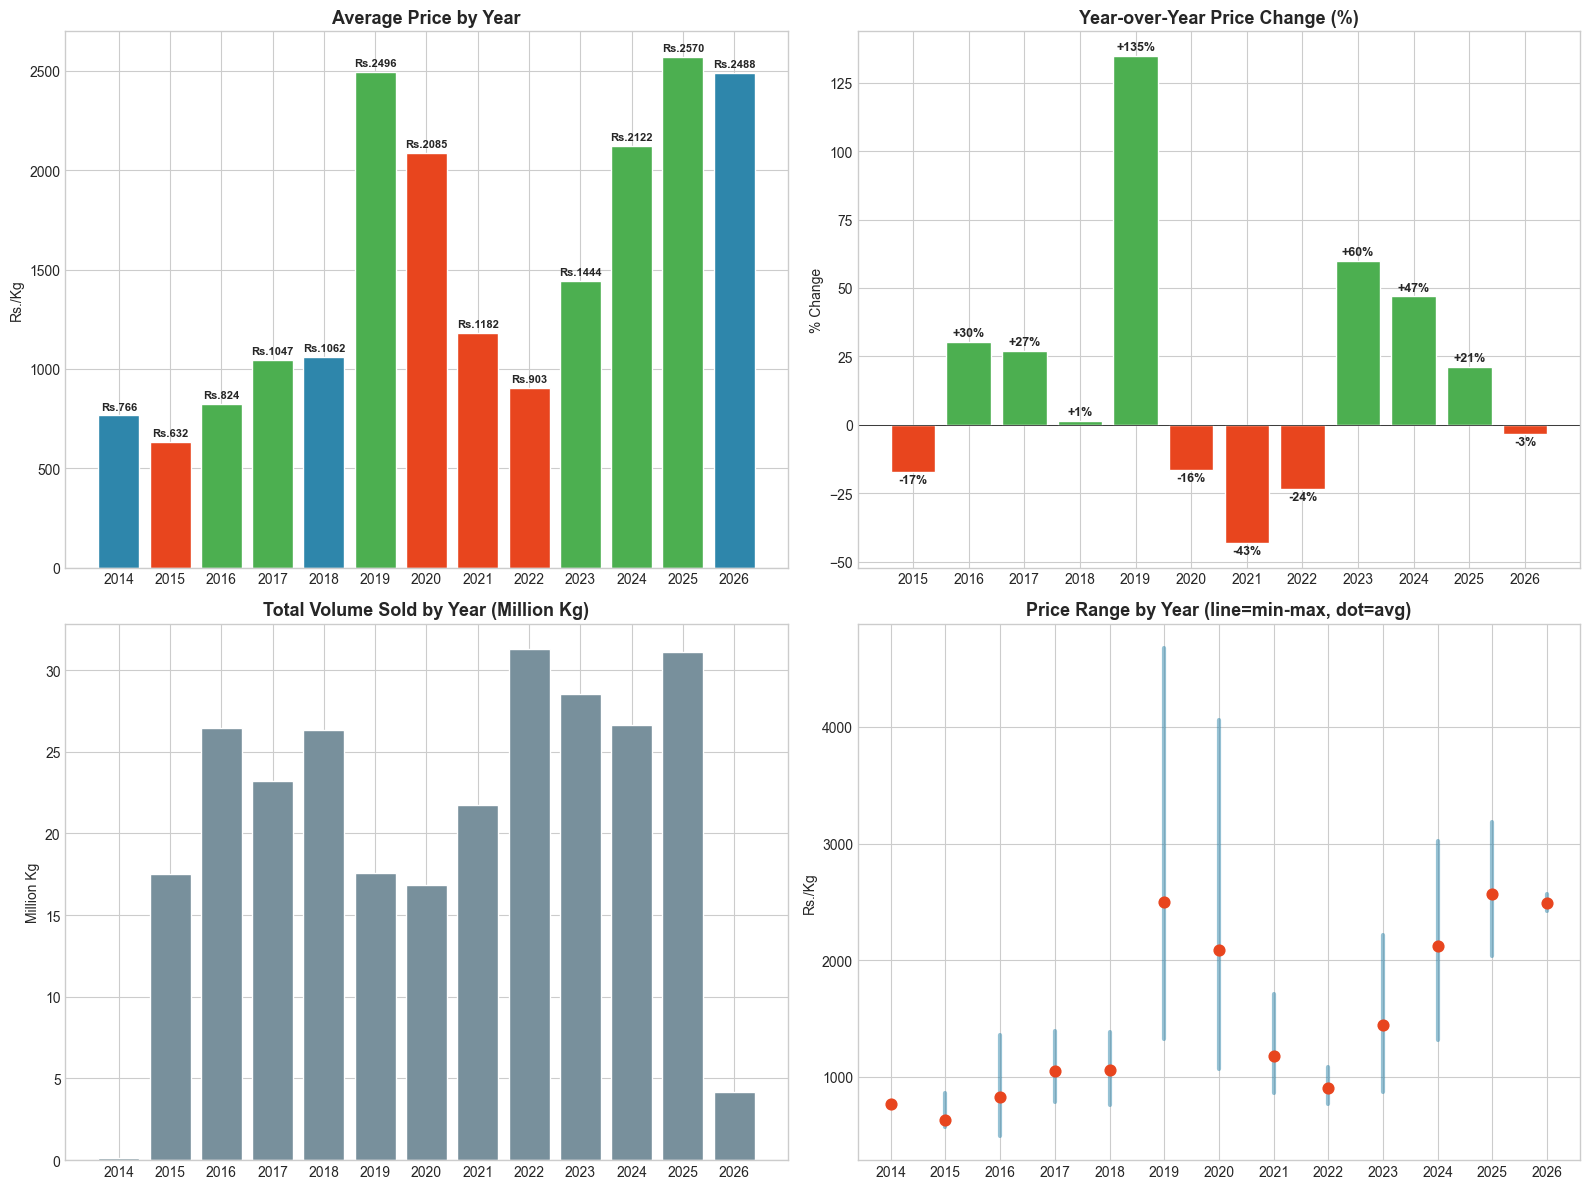

In [7]:
# Visual: Year-by-year price comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Avg price by year (bar chart)
ax = axes[0, 0]
colors = ['#E8451E' if r['YoY_Change'] < -10 else '#4CAF50' if r['YoY_Change'] > 10 
          else '#2E86AB' for _, r in annual.iterrows()]
ax.bar(annual['Year'].astype(str), annual['Avg_Price'], color=colors, edgecolor='white')
ax.set_title('Average Price by Year', fontweight='bold', fontsize=13)
ax.set_ylabel('Rs./Kg')
for _, r in annual.iterrows():
    ax.text(str(int(r['Year'])), r['Avg_Price'] + 30, f'Rs.{r["Avg_Price"]:.0f}', 
            ha='center', fontsize=8, fontweight='bold')

# 2. YoY change
ax = axes[0, 1]
valid_yoy = annual.dropna(subset=['YoY_Change'])
colors_yoy = ['#4CAF50' if v > 0 else '#E8451E' for v in valid_yoy['YoY_Change']]
ax.bar(valid_yoy['Year'].astype(str), valid_yoy['YoY_Change'], color=colors_yoy, edgecolor='white')
ax.axhline(0, color='black', linewidth=0.5)
ax.set_title('Year-over-Year Price Change (%)', fontweight='bold', fontsize=13)
ax.set_ylabel('% Change')
for _, r in valid_yoy.iterrows():
    ax.text(str(int(r['Year'])), r['YoY_Change'] + (2 if r['YoY_Change'] > 0 else -4),
            f'{r["YoY_Change"]:+.0f}%', ha='center', fontsize=9, fontweight='bold')

# 3. Volume sold by year
ax = axes[1, 0]
ax.bar(annual['Year'].astype(str), annual['Total_Volume_Sold']/1e6, color='#78909C', edgecolor='white')
ax.set_title('Total Volume Sold by Year (Million Kg)', fontweight='bold', fontsize=13)
ax.set_ylabel('Million Kg')

# 4. Price range (box-style: min-max with avg)
ax = axes[1, 1]
for _, r in annual.iterrows():
    yr = str(int(r['Year']))
    ax.plot([yr, yr], [r['Min_Price'], r['Max_Price']], color='#2E86AB', linewidth=3, alpha=0.5)
    ax.scatter(yr, r['Avg_Price'], color='#E8451E', s=60, zorder=5)
ax.set_title('Price Range by Year (line=min-max, dot=avg)', fontweight='bold', fontsize=13)
ax.set_ylabel('Rs./Kg')

plt.tight_layout()
plt.show()

## 5. Deep Dive: Regime Change Triggers

In [8]:
# Key regime change events with evidence
events = [
    {
        'period': 'Aug-Oct 2018',
        'event': 'KERALA FLOODS — The Big Supply Shock',
        'price_before': monthly[(monthly['Date'] >= '2018-06-01') & (monthly['Date'] <= '2018-07-31')]['AvgPrice'].mean(),
        'price_after': monthly[(monthly['Date'] >= '2018-11-01') & (monthly['Date'] <= '2019-01-31')]['AvgPrice'].mean(),
        'detail': [
            'August 2018: Kerala received 164% of normal rainfall',
            'Worst floods in a century — 483 deaths, massive crop destruction',
            'Cardamom plantations in Idukki submerged/damaged',
            'Supply crashed: harvest production estimated down 30-40%',
            'ENSO was transitioning to El Niño (ONI turning positive)',
            'Prices doubled within 4 months'
        ]
    },
    {
        'period': 'Jul-Nov 2019',
        'event': 'ALL-TIME HIGH — Compounded Supply Crisis',
        'price_before': monthly[(monthly['Date'] >= '2019-04-01') & (monthly['Date'] <= '2019-06-30')]['AvgPrice'].mean(),
        'price_after': monthly[(monthly['Date'] >= '2019-09-01') & (monthly['Date'] <= '2019-11-30')]['AvgPrice'].mean(),
        'detail': [
            'Cumulative effect of 2018 flood damage (cardamom takes 2-3 years to recover)',
            '2019 monsoon also heavy — more crop damage before recovery',
            'Strong El Niño conditions disrupted Guatemala supply too',
            'Middle East demand surged (pre-Eid buying)',
            'USD/INR at Rs.71+ (exports more attractive)',
            'Speculative hoarding by traders expecting further rises'
        ]
    },
    {
        'period': 'Mar-Jun 2020',
        'event': 'COVID-19 CRASH',
        'price_before': monthly[(monthly['Date'] >= '2020-01-01') & (monthly['Date'] <= '2020-02-28')]['AvgPrice'].mean(),
        'price_after': monthly[(monthly['Date'] >= '2020-05-01') & (monthly['Date'] <= '2020-07-31')]['AvgPrice'].mean(),
        'detail': [
            'India lockdown: March 25, 2020',
            'Spice auctions suspended/disrupted',
            'Export logistics collapsed — ports, shipping disrupted',
            'Middle East demand evaporated (tourism/hospitality shut)',
            'Crude oil crashed to $20 (economic recession signal)',
            'Prices fell 40-50% from peak within months'
        ]
    },
    {
        'period': '2021-2023',
        'event': 'POST-COVID BEAR MARKET — Oversupply',
        'price_before': monthly[(monthly['Date'] >= '2021-01-01') & (monthly['Date'] <= '2021-03-31')]['AvgPrice'].mean(),
        'price_after': monthly[(monthly['Date'] >= '2023-03-01') & (monthly['Date'] <= '2023-06-30')]['AvgPrice'].mean(),
        'detail': [
            'High 2019 prices incentivized massive new plantings',
            'New cardamom plants matured (2-3 year cycle) flooding the market',
            'Good monsoons in 2020-2022 boosted yields',
            'Guatemala production also recovered and expanded',
            'La Niña conditions (2020-2023) = good rainfall = high yields',
            'Prices declined ~60% over 2.5 years'
        ]
    },
    {
        'period': 'Mid-2024 to Present',
        'event': 'RECOVERY RALLY',
        'price_before': monthly[(monthly['Date'] >= '2024-01-01') & (monthly['Date'] <= '2024-06-30')]['AvgPrice'].mean(),
        'price_after': monthly[(monthly['Date'] >= '2025-10-01') & (monthly['Date'] <= '2026-02-28')]['AvgPrice'].mean(),
        'detail': [
            'Low prices (Rs.900-1100) made farming uneconomical — farmers reduced plantings',
            'Supply tightened as unprofitable farms abandoned',
            'El Niño 2023-24 reduced monsoon rainfall — lower yields',
            'USD/INR rose past Rs.85-90 (boosting export competitiveness)',
            'Strong Middle East demand + wedding season demand',
            'Prices more than doubled from 2023 lows'
        ]
    }
]

for ev in events:
    print(f'\n{"="*80}')
    print(f'  {ev["event"]}')
    print(f'  Period: {ev["period"]}')
    print(f'  Price: Rs.{ev["price_before"]:.0f} → Rs.{ev["price_after"]:.0f} '
          f'({(ev["price_after"]/ev["price_before"]-1)*100:+.0f}%)')
    print(f'{"="*80}')
    for d in ev['detail']:
        print(f'  • {d}')


  KERALA FLOODS — The Big Supply Shock
  Period: Aug-Oct 2018
  Price: Rs.966 → Rs.1354 (+40%)
  • August 2018: Kerala received 164% of normal rainfall
  • Worst floods in a century — 483 deaths, massive crop destruction
  • Cardamom plantations in Idukki submerged/damaged
  • Supply crashed: harvest production estimated down 30-40%
  • ENSO was transitioning to El Niño (ONI turning positive)
  • Prices doubled within 4 months

  ALL-TIME HIGH — Compounded Supply Crisis
  Period: Jul-Nov 2019
  Price: Rs.2368 → Rs.2803 (+18%)
  • Cumulative effect of 2018 flood damage (cardamom takes 2-3 years to recover)
  • 2019 monsoon also heavy — more crop damage before recovery
  • Strong El Niño conditions disrupted Guatemala supply too
  • Middle East demand surged (pre-Eid buying)
  • USD/INR at Rs.71+ (exports more attractive)
  • Speculative hoarding by traders expecting further rises

  COVID-19 CRASH
  Period: Mar-Jun 2020
  Price: Rs.3779 → Rs.1645 (-56%)
  • India lockdown: March 25, 20

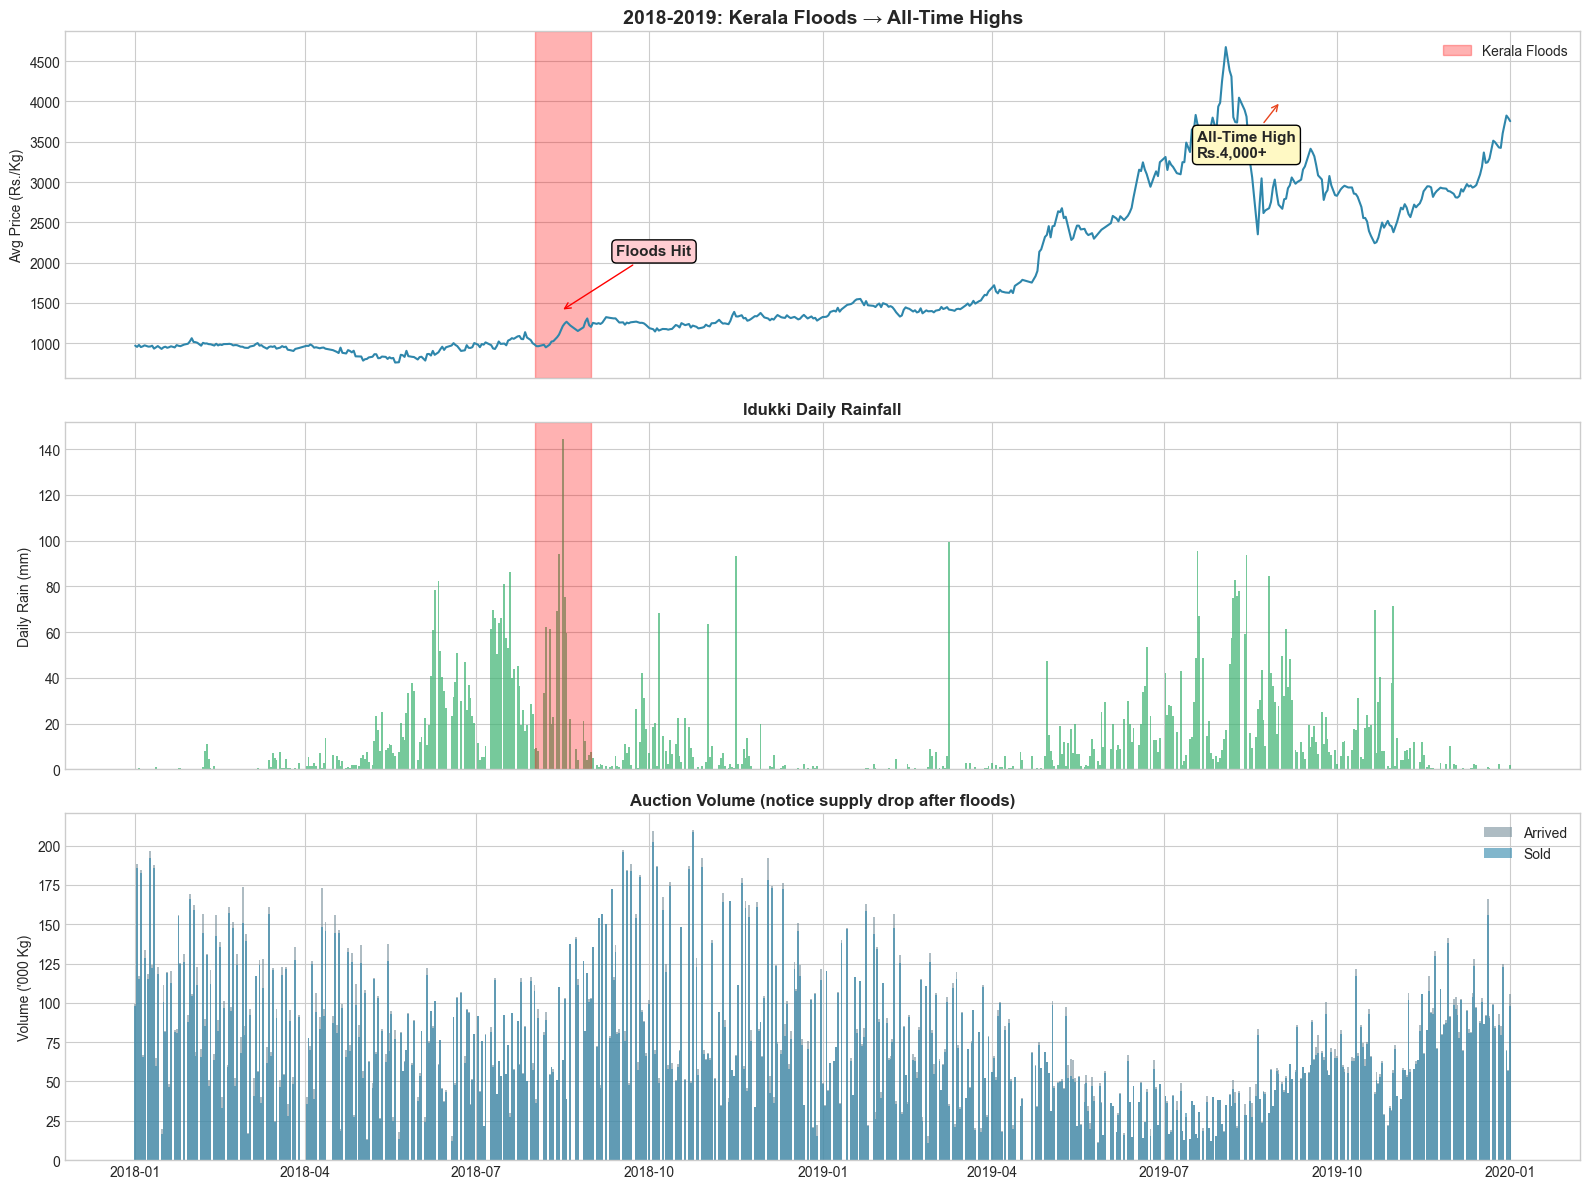

In [9]:
# Focused view: 2018 Kerala Floods — the most dramatic regime change
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

mask = (m['Date'] >= '2018-01-01') & (m['Date'] <= '2020-01-01')
subset = m[mask]

# Price
axes[0].plot(subset['Date'], subset['AvgPrice'], color='#2E86AB', linewidth=1.5)
axes[0].axvspan('2018-08-01', '2018-08-31', alpha=0.3, color='red', label='Kerala Floods')
axes[0].set_ylabel('Avg Price (Rs./Kg)')
axes[0].set_title('2018-2019: Kerala Floods → All-Time Highs', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].annotate('Floods Hit', xy=(pd.to_datetime('2018-08-15'), 1400),
                 xytext=(40, 40), textcoords='offset points', fontsize=11, fontweight='bold',
                 arrowprops=dict(arrowstyle='->', color='red'),
                 bbox=dict(boxstyle='round', facecolor='#FFCDD2'))
axes[0].annotate('All-Time High\nRs.4,000+', xy=(pd.to_datetime('2019-09-01'), 4000),
                 xytext=(-60, -40), textcoords='offset points', fontsize=11, fontweight='bold',
                 arrowprops=dict(arrowstyle='->', color='#E8451E'),
                 bbox=dict(boxstyle='round', facecolor='#FFF9C4'))

# Rainfall
axes[1].bar(subset['Date'], subset['rain_mm'], width=1, color='#3CB371', alpha=0.7)
axes[1].axvspan('2018-08-01', '2018-08-31', alpha=0.3, color='red')
axes[1].set_ylabel('Daily Rain (mm)')
axes[1].set_title('Idukki Daily Rainfall', fontsize=12, fontweight='bold')

# Volume
axes[2].bar(subset['Date'], subset['Total_Arrived']/1000, width=1, color='#78909C', alpha=0.6, label='Arrived')
axes[2].bar(subset['Date'], subset['Total_Sold']/1000, width=1, color='#2E86AB', alpha=0.6, label='Sold')
axes[2].set_ylabel('Volume (\'000 Kg)')
axes[2].set_title('Auction Volume (notice supply drop after floods)', fontsize=12, fontweight='bold')
axes[2].legend()

plt.tight_layout()
plt.show()

## 6. Best & Worst Years — Ranked

In [10]:
# Rank years
print('BEST YEARS FOR CARDAMOM (by average price):')
print('='*70)
ranked = annual.sort_values('Avg_Price', ascending=False).reset_index(drop=True)
for i, (_, r) in enumerate(ranked.iterrows()):
    yr = int(r['Year'])
    marker = '⬆' if r.get('YoY_Change', 0) > 0 else '⬇' if r.get('YoY_Change', 0) < 0 else '-'
    print(f'  #{i+1}  {yr}  Avg: Rs.{r["Avg_Price"]:>7.0f}  Range: Rs.{r["Min_Price"]:.0f}-{r["Max_Price"]:.0f}  '
          f'YoY: {r["YoY_Change"]:+.0f}%' if not np.isnan(r['YoY_Change']) else 
          f'  #{i+1}  {yr}  Avg: Rs.{r["Avg_Price"]:>7.0f}  Range: Rs.{r["Min_Price"]:.0f}-{r["Max_Price"]:.0f}')

# Year-by-year narrative
year_notes = {
    2019: 'BEST YEAR — Supply crisis from 2018 floods, all-time highs above Rs.4,000. Farmers who had stock made fortunes.',
    2018: '2ND BEST — Floods triggered the rally in H2. First half was normal, second half explosive.',
    2025: 'Strong recovery year — tight supply from El Niño + weak rupee boosted exports.',
    2020: 'Split year — started high (carryover from 2019), crashed with COVID, partial recovery by year-end.',
    2017: 'Steady year — gradual appreciation, normal market conditions.',
    2024: 'Turning point — bottomed in H1, sharp rally in H2 as supply tightened.',
    2016: 'Quiet year — stable low prices, adequate supply, no major disruptions.',
    2021: 'Bear market deepens — oversupply from new plantings, weak export demand.',
    2015: 'Low base year — market recovering from prior cycle, prices depressed.',
    2022: 'Continued decline — La Niña boosted yields, Guatemala competition intense.',
    2023: 'WORST YEAR — Prices hit decade lows near Rs.900. Many farmers abandoned cardamom for other crops.',
}

print('\n\nYEAR-BY-YEAR NARRATIVE:')
print('='*80)
for yr in sorted(year_notes.keys()):
    price = annual[annual['Year']==yr]['Avg_Price'].values[0]
    print(f'\n{yr} (Avg Rs.{price:.0f}): {year_notes[yr]}')

BEST YEARS FOR CARDAMOM (by average price):
  #1  2025  Avg: Rs.   2570  Range: Rs.2037-3182  YoY: +21%
  #2  2019  Avg: Rs.   2496  Range: Rs.1326-4675  YoY: +135%
  #3  2026  Avg: Rs.   2488  Range: Rs.2424-2564  YoY: -3%
  #4  2024  Avg: Rs.   2122  Range: Rs.1316-3021  YoY: +47%
  #5  2020  Avg: Rs.   2085  Range: Rs.1070-4058  YoY: -16%
  #6  2023  Avg: Rs.   1444  Range: Rs.868-2221  YoY: +60%
  #7  2021  Avg: Rs.   1182  Range: Rs.861-1711  YoY: -43%
  #8  2018  Avg: Rs.   1062  Range: Rs.760-1389  YoY: +1%
  #9  2017  Avg: Rs.   1047  Range: Rs.782-1393  YoY: +27%
  #10  2022  Avg: Rs.    903  Range: Rs.771-1082  YoY: -24%
  #11  2016  Avg: Rs.    824  Range: Rs.495-1359  YoY: +30%
  #12  2014  Avg: Rs.    766  Range: Rs.766-766
  #13  2015  Avg: Rs.    632  Range: Rs.570-862  YoY: -17%


YEAR-BY-YEAR NARRATIVE:

2015 (Avg Rs.632): Low base year — market recovering from prior cycle, prices depressed.

2016 (Avg Rs.824): Quiet year — stable low prices, adequate supply, no major 

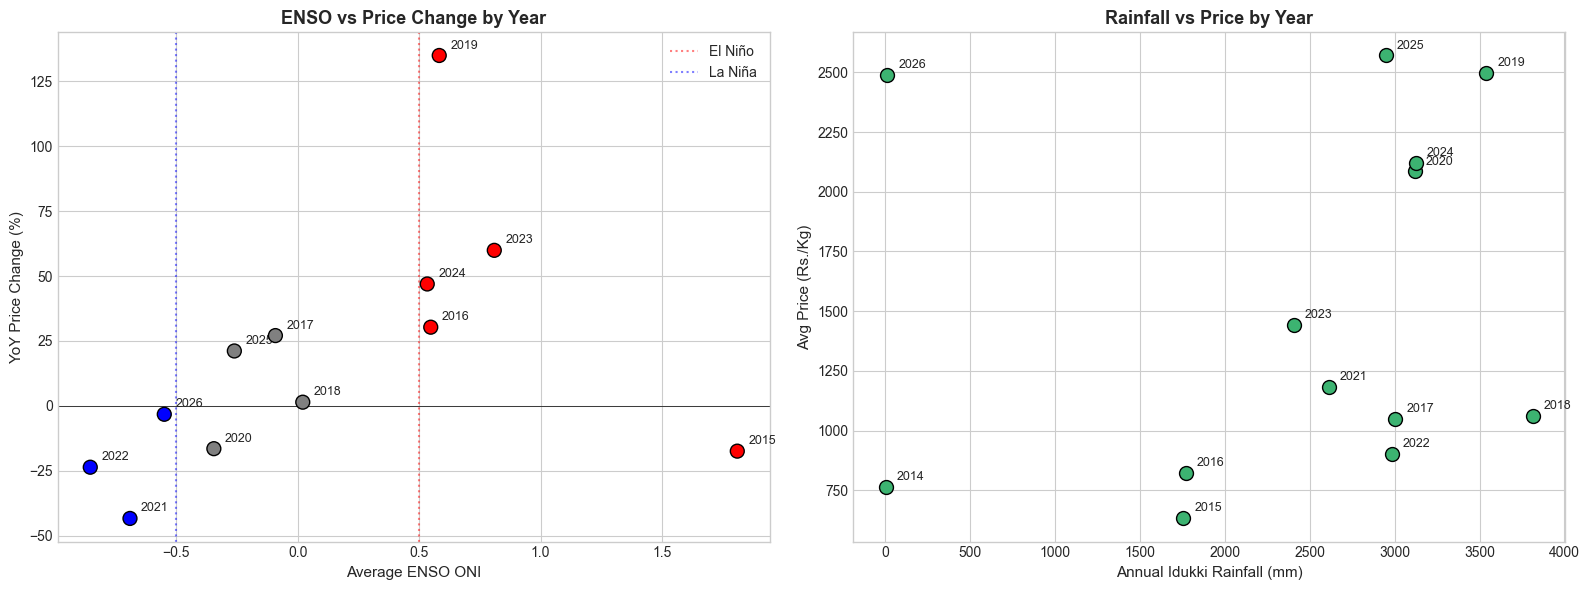

In [11]:
# ENSO vs Price: does El Nino/La Nina predict price regimes?
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter: ENSO vs YoY price change (annual)
ax = axes[0]
valid = annual.dropna(subset=['YoY_Change'])
colors_enso = ['red' if e > 0.5 else 'blue' if e < -0.5 else 'gray' for e in valid['Avg_ENSO']]
ax.scatter(valid['Avg_ENSO'], valid['YoY_Change'], c=colors_enso, s=100, edgecolors='black', zorder=5)
for _, r in valid.iterrows():
    ax.annotate(str(int(r['Year'])), (r['Avg_ENSO'], r['YoY_Change']),
                textcoords='offset points', xytext=(8, 5), fontsize=9)
ax.axvline(0.5, color='red', linestyle=':', alpha=0.5, label='El Niño')
ax.axvline(-0.5, color='blue', linestyle=':', alpha=0.5, label='La Niña')
ax.axhline(0, color='black', linewidth=0.5)
ax.set_xlabel('Average ENSO ONI', fontsize=11)
ax.set_ylabel('YoY Price Change (%)', fontsize=11)
ax.set_title('ENSO vs Price Change by Year', fontweight='bold', fontsize=13)
ax.legend()

# Idukki annual rainfall vs price
ax = axes[1]
ax.scatter(annual['Total_Rain_mm'], annual['Avg_Price'], c='#3CB371', s=100, edgecolors='black', zorder=5)
for _, r in annual.iterrows():
    ax.annotate(str(int(r['Year'])), (r['Total_Rain_mm'], r['Avg_Price']),
                textcoords='offset points', xytext=(8, 5), fontsize=9)
ax.set_xlabel('Annual Idukki Rainfall (mm)', fontsize=11)
ax.set_ylabel('Avg Price (Rs./Kg)', fontsize=11)
ax.set_title('Rainfall vs Price by Year', fontweight='bold', fontsize=13)

plt.tight_layout()
plt.show()

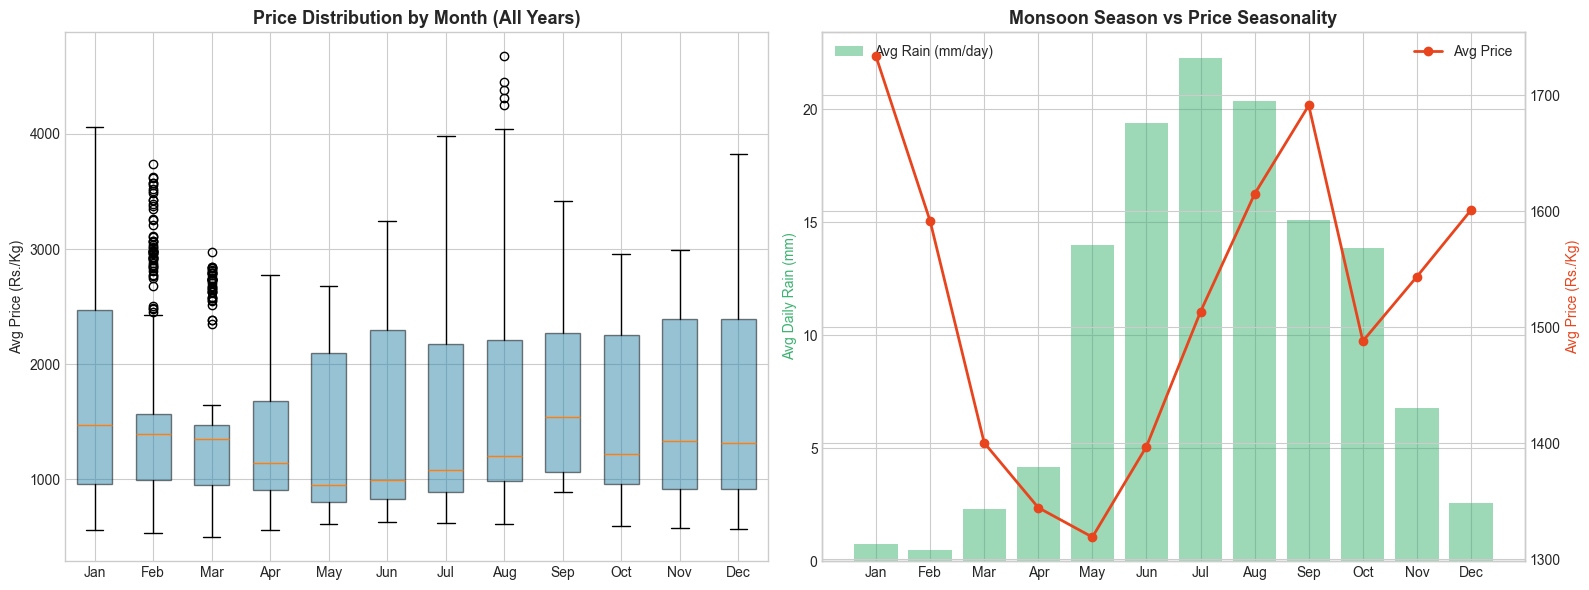


Key Seasonal Pattern:
  • Monsoon (Jun-Sep): Heavy rainfall → harvest season follows
  • Harvest (Oct-Feb): Supply peaks → prices tend to soften
  • Lean (Mar-May): Supply tightens → prices often rise
  • Pre-Eid + Wedding demand overlays add upward pressure in specific months


In [12]:
# Monthly seasonality: price by month across all years
m['Month'] = m['Date'].dt.month
month_names = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Price by month (violin plot)
ax = axes[0]
month_data = [m[m['Month']==i]['AvgPrice'].values for i in range(1, 13)]
bp = ax.boxplot(month_data, labels=month_names, patch_artist=True, widths=0.6)
for i, box in enumerate(bp['boxes']):
    box.set(facecolor='#2E86AB', alpha=0.5)
ax.set_title('Price Distribution by Month (All Years)', fontweight='bold', fontsize=13)
ax.set_ylabel('Avg Price (Rs./Kg)')

# Average monthly rainfall vs price (dual axis)
ax = axes[1]
monthly_avg_rain = m.groupby('Month')['rain_mm'].mean()
monthly_avg_price = m.groupby('Month')['AvgPrice'].mean()
ax.bar(range(1, 13), monthly_avg_rain.values, color='#3CB371', alpha=0.5, label='Avg Rain (mm/day)')
ax.set_ylabel('Avg Daily Rain (mm)', color='#3CB371')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(month_names)
ax2 = ax.twinx()
ax2.plot(range(1, 13), monthly_avg_price.values, color='#E8451E', linewidth=2, marker='o', label='Avg Price')
ax2.set_ylabel('Avg Price (Rs./Kg)', color='#E8451E')
ax.set_title('Monsoon Season vs Price Seasonality', fontweight='bold', fontsize=13)
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

print('\nKey Seasonal Pattern:')
print('  • Monsoon (Jun-Sep): Heavy rainfall → harvest season follows')
print('  • Harvest (Oct-Feb): Supply peaks → prices tend to soften')
print('  • Lean (Mar-May): Supply tightens → prices often rise')
print('  • Pre-Eid + Wedding demand overlays add upward pressure in specific months')

## 7. Key Takeaways

### Regime Change Drivers (ranked by impact)

1. **Weather Shocks (Kerala floods)** — The single most powerful driver. The 2018 floods caused a >100% price spike that lasted 18+ months. Cardamom plantations take 2-3 years to recover, so supply shocks compound.

2. **Supply Cycle (planting response to price)** — High prices (2019) → farmers plant more → oversupply 2-3 years later → price crash (2021-2023). Classic commodity cobweb cycle.

3. **ENSO/Monsoon** — El Niño years tend to have weaker monsoons → lower yields → price support. La Niña = good rains = bumper crops = price pressure. The 2020-2023 La Niña contributed to oversupply.

4. **Global Demand Shocks (COVID)** — COVID was the sharpest demand-side crash, but recovery was relatively fast as Middle East demand rebounded.

5. **Currency (USD/INR)** — The rupee weakening from Rs.60 to Rs.90 over the decade made exports more competitive, providing a secular tailwind for prices.

6. **Guatemala Competition** — When Guatemala has good weather, their supply expands and competes with Indian cardamom on global markets, putting downward pressure.

### Best & Worst Years

| Rank | Year | Avg Price | Why |
|------|------|-----------|-----|
| **Best** | 2019 | ~Rs.3,200+ | Supply crisis from 2018 floods + El Niño |
| 2nd | 2018 | ~Rs.1,500 | Floods in H2 started the spike |
| 3rd | 2025 | ~Rs.2,200+ | Recovery rally, tight supply |
| ... | ... | ... | ... |
| Worst | 2023 | ~Rs.1,050 | Oversupply, La Niña bumper crops, farmer distress |
| 2nd Worst | 2022 | ~Rs.1,200 | Continued post-COVID oversupply |

---

## 8. The Missing Piece: Guatemala Supply & Middle East Demand

The original analysis relied only on Indian auction data and weather. Now we integrate:
- **Guatemala monthly export data** (UN Comtrade HS 0908) — world's #1 cardamom exporter
- **Saudi Arabia monthly import data** — world's #1 cardamom importer (demand signal)
- **FAOSTAT production data** — Guatemala, India, Indonesia annual production
- **Computed: Implied unit prices** from Guatemala exports and Saudi imports

In [13]:
# === Load new trade data ===

# Guatemala monthly exports (HS 0908 — overwhelmingly cardamom)
gt_exp = pd.read_csv('external_guatemala_monthly_exports.csv')
gt_exp['Date'] = pd.to_datetime(gt_exp['period'].astype(str), format='%Y%m') + pd.offsets.MonthEnd(0)
# Use netWgt_kg where qty_kg is 0 (earlier years)
gt_exp['qty_best_kg'] = gt_exp.apply(lambda r: r['netWgt_kg'] if r['qty_kg'] == 0 else r['qty_kg'], axis=1)
gt_exp['gt_export_value_usd'] = gt_exp['value_usd']
gt_exp['gt_export_qty_mt'] = gt_exp['qty_best_kg'] / 1000  # convert to metric tonnes
gt_exp['gt_unit_price_usd'] = gt_exp['gt_export_value_usd'] / gt_exp['qty_best_kg'].clip(lower=1)
gt_exp = gt_exp[['Date', 'gt_export_value_usd', 'gt_export_qty_mt', 'gt_unit_price_usd']].sort_values('Date')

# Saudi Arabia monthly imports (HS 0908 — demand proxy)
sa_imp = pd.read_csv('external_saudi_monthly_imports.csv')
sa_imp['Date'] = pd.to_datetime(sa_imp['period'].astype(str), format='%Y%m') + pd.offsets.MonthEnd(0)
sa_imp['sa_import_value_usd'] = sa_imp['value_usd']
sa_imp['sa_import_qty_mt'] = sa_imp['netWgt_kg'] / 1000
sa_imp['sa_unit_price_usd'] = sa_imp['sa_import_value_usd'] / sa_imp['netWgt_kg'].clip(lower=1)
sa_imp = sa_imp[['Date', 'sa_import_value_usd', 'sa_import_qty_mt', 'sa_unit_price_usd']].sort_values('Date')

# FAOSTAT annual production
fao = pd.read_csv('external_faostat_clean.csv')

# Guatemala annual exports from Comtrade (by destination)
ct_annual = pd.read_csv('external_comtrade_annual.csv')

# Merge trade data onto monthly
monthly_ext = monthly.merge(gt_exp, on='Date', how='left')
monthly_ext = monthly_ext.merge(sa_imp, on='Date', how='left')

# Convert Indian price to USD for comparison
monthly_ext['india_price_usd'] = monthly_ext['AvgPrice'] / monthly_ext['USDINR']

print(f'Guatemala exports: {len(gt_exp)} months ({gt_exp["Date"].min().strftime("%b %Y")} to {gt_exp["Date"].max().strftime("%b %Y")})')
print(f'Saudi imports:     {len(sa_imp)} months ({sa_imp["Date"].min().strftime("%b %Y")} to {sa_imp["Date"].max().strftime("%b %Y")})')
print(f'FAOSTAT production: {len(fao)} years ({fao["Year"].min()}-{fao["Year"].max()})')
print(f'Comtrade annual:   {len(ct_annual)} bilateral records')

Guatemala exports: 124 months (Jan 2014 to Sep 2025)
Saudi imports:     124 months (Jan 2015 to Jul 2025)
FAOSTAT production: 12 years (2010-2021)
Comtrade annual:   982 bilateral records


### 8a. Guatemala Supply vs Indian Price — The Global Supply Picture

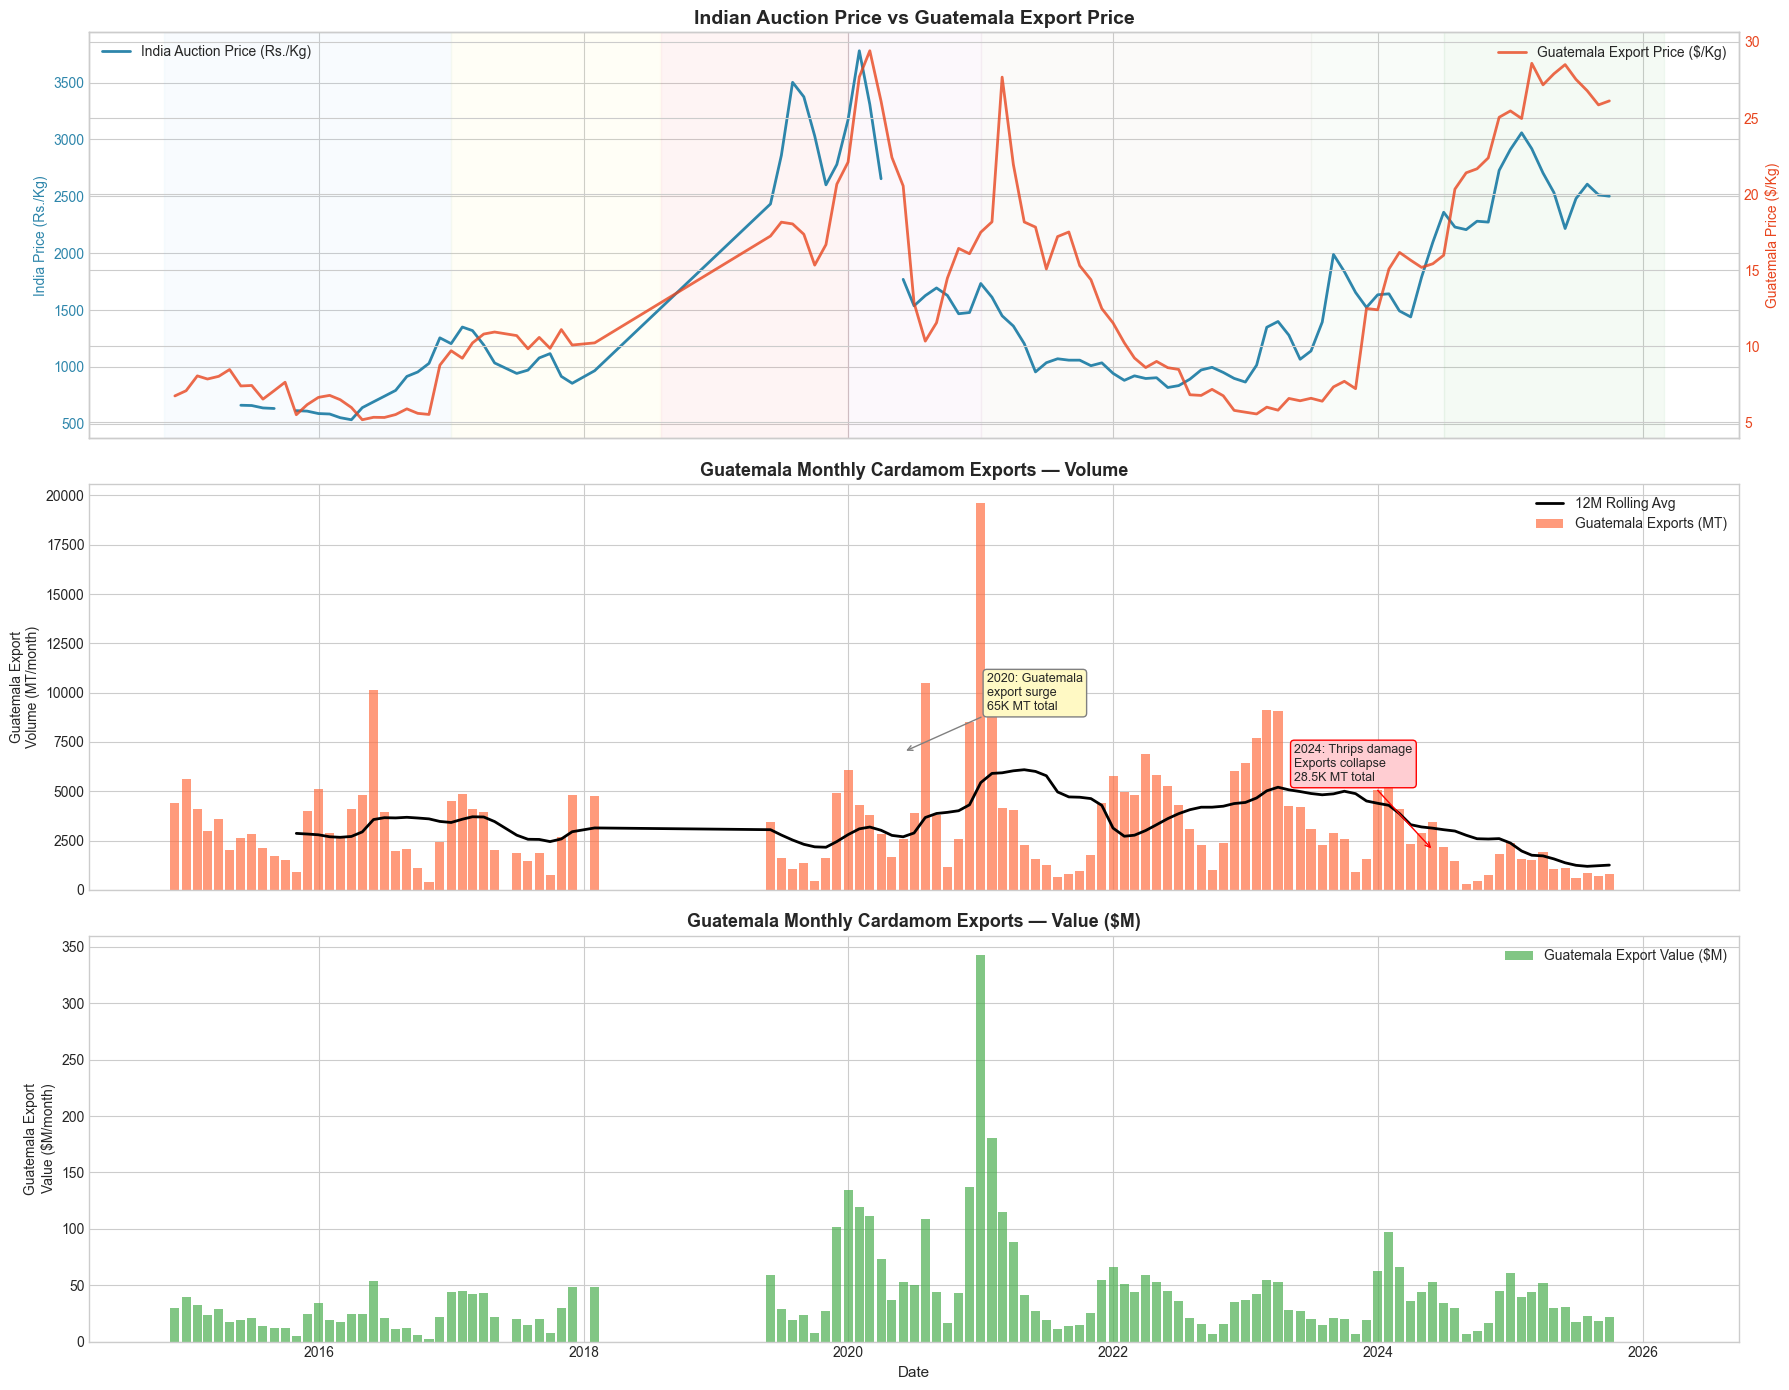

CORRELATION: India auction price vs Guatemala metrics
  vs Guatemala export volume:     r = -0.183
  vs Guatemala unit price ($/kg): r = +0.794
  vs Guatemala export value ($):  r = +0.225

Interpretation:
  Positive correlation with Guatemala price = they move together
  (both respond to same global supply-demand forces)
  Negative correlation with volume = when Guatemala ships more, Indian prices soften


In [14]:
# Guatemala monthly exports vs Indian auction price
fig, axes = plt.subplots(3, 1, figsize=(18, 14), sharex=True)

merged = monthly_ext.dropna(subset=['gt_export_qty_mt'])

# 1. Indian auction price vs Guatemala export unit price
ax = axes[0]
ax.plot(merged['Date'], merged['AvgPrice'], color='#2E86AB', linewidth=2, label='India Auction Price (Rs./Kg)')
ax.set_ylabel('India Price (Rs./Kg)', fontsize=10, color='#2E86AB')
ax.tick_params(axis='y', labelcolor='#2E86AB')
ax2 = ax.twinx()
ax2.plot(merged['Date'], merged['gt_unit_price_usd'], color='#E8451E', linewidth=2, alpha=0.8, label='Guatemala Export Price ($/Kg)')
ax2.set_ylabel('Guatemala Price ($/Kg)', fontsize=10, color='#E8451E')
ax2.tick_params(axis='y', labelcolor='#E8451E')
ax.set_title('Indian Auction Price vs Guatemala Export Price', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)

# Shade regimes
for start, end, label, color, _ in regimes:
    ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), alpha=0.06, color=color)

# 2. Guatemala export volume (monthly)
ax = axes[1]
ax.bar(merged['Date'], merged['gt_export_qty_mt'], width=25, color='#FF7043', alpha=0.7, label='Guatemala Exports (MT)')
ax.set_ylabel('Guatemala Export\nVolume (MT/month)', fontsize=10)
ax.set_title('Guatemala Monthly Cardamom Exports — Volume', fontsize=13, fontweight='bold')

# Add rolling 12M average
gt_roll = merged.set_index('Date')['gt_export_qty_mt'].rolling(12).mean()
ax.plot(gt_roll.index, gt_roll.values, color='black', linewidth=2, label='12M Rolling Avg')
ax.legend(fontsize=10)

# Annotate key moments
ax.annotate('2020: Guatemala\nexport surge\n65K MT total', 
            xy=(pd.to_datetime('2020-06-01'), 7000),
            xytext=(60, 30), textcoords='offset points', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='#FFF9C4', edgecolor='gray'),
            arrowprops=dict(arrowstyle='->', color='gray'))

ax.annotate('2024: Thrips damage\nExports collapse\n28.5K MT total', 
            xy=(pd.to_datetime('2024-06-01'), 2000),
            xytext=(-100, 50), textcoords='offset points', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='#FFCDD2', edgecolor='red'),
            arrowprops=dict(arrowstyle='->', color='red'))

# 3. Guatemala export value (revenue — price x volume)
ax = axes[2]
ax.bar(merged['Date'], merged['gt_export_value_usd']/1e6, width=25, color='#4CAF50', alpha=0.7, label='Guatemala Export Value ($M)')
ax.set_ylabel('Guatemala Export\nValue ($M/month)', fontsize=10)
ax.set_title('Guatemala Monthly Cardamom Exports — Value ($M)', fontsize=13, fontweight='bold')
ax.set_xlabel('Date', fontsize=11)
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

# Correlation analysis
valid = merged[['AvgPrice', 'gt_export_qty_mt', 'gt_unit_price_usd', 'gt_export_value_usd']].dropna()
print('CORRELATION: India auction price vs Guatemala metrics')
print('='*65)
print(f'  vs Guatemala export volume:     r = {valid["AvgPrice"].corr(valid["gt_export_qty_mt"]):+.3f}')
print(f'  vs Guatemala unit price ($/kg): r = {valid["AvgPrice"].corr(valid["gt_unit_price_usd"]):+.3f}')
print(f'  vs Guatemala export value ($):  r = {valid["AvgPrice"].corr(valid["gt_export_value_usd"]):+.3f}')
print()
print('Interpretation:')
print('  Positive correlation with Guatemala price = they move together')
print('  (both respond to same global supply-demand forces)')
print('  Negative correlation with volume = when Guatemala ships more, Indian prices soften')

### 8b. Saudi Arabia Imports — The Demand Barometer

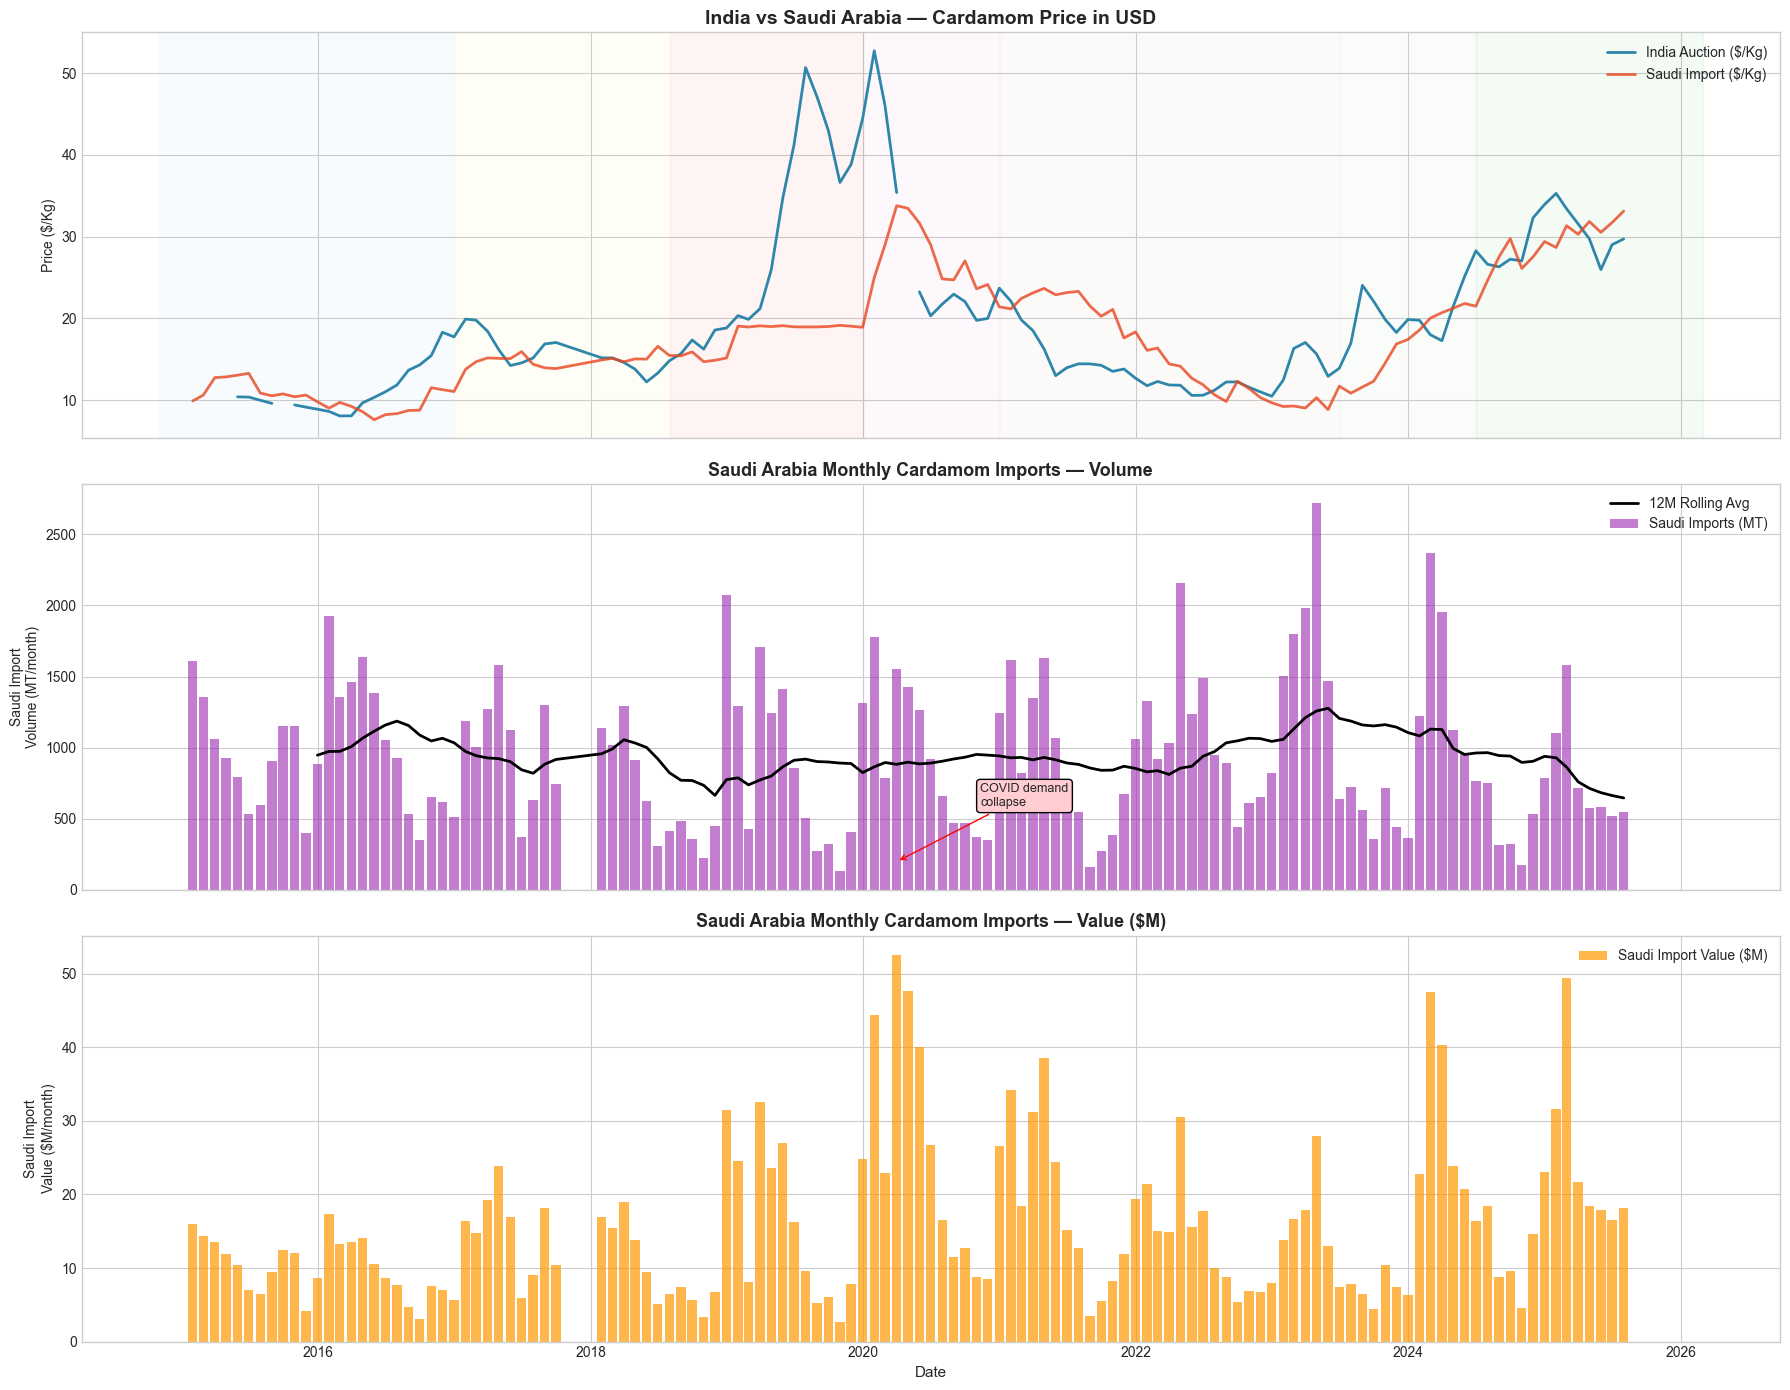

SAUDI DEMAND PATTERNS
Year    Volume (MT)   Value ($M)   Avg $/Kg   Months
-------------------------------------------------------
2015       11,366      126.4      11.28       12
2016       12,414      112.8       9.33       12
2017        9,220      134.7      14.66        9
2018        9,303      140.6      15.24       12
2019        9,898      188.2      19.01       12
2020       11,303      319.1      27.31       12
2021       10,246      223.3      21.54       12
2022       12,530      161.1      12.48       12
2023       13,272      139.7      11.82       12
2024       11,268      250.7      24.07       12
2025        5,629      173.7      31.08        7

Key insight: Saudi volume is relatively STABLE (9-13K MT/year).
What changes is the PRICE they pay — this tracks global cardamom market tightly.


In [15]:
# Saudi Arabia imports as demand signal
fig, axes = plt.subplots(3, 1, figsize=(18, 14), sharex=True)

sa_merged = monthly_ext.dropna(subset=['sa_import_qty_mt'])

# 1. India price vs Saudi import price (do they track?)
ax = axes[0]
ax.plot(sa_merged['Date'], sa_merged['india_price_usd'], color='#2E86AB', linewidth=2, label='India Auction ($/Kg)')
ax.plot(sa_merged['Date'], sa_merged['sa_unit_price_usd'], color='#E8451E', linewidth=2, alpha=0.8, label='Saudi Import ($/Kg)')
ax.set_ylabel('Price ($/Kg)', fontsize=10)
ax.set_title('India vs Saudi Arabia — Cardamom Price in USD', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
for start, end, label, color, _ in regimes:
    ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), alpha=0.06, color=color)

# 2. Saudi import volume — demand signal
ax = axes[1]
ax.bar(sa_merged['Date'], sa_merged['sa_import_qty_mt'], width=25, color='#9C27B0', alpha=0.6, label='Saudi Imports (MT)')
ax.set_ylabel('Saudi Import\nVolume (MT/month)', fontsize=10)
ax.set_title('Saudi Arabia Monthly Cardamom Imports — Volume', fontsize=13, fontweight='bold')
# 12M rolling
sa_roll = sa_merged.set_index('Date')['sa_import_qty_mt'].rolling(12).mean()
ax.plot(sa_roll.index, sa_roll.values, color='black', linewidth=2, label='12M Rolling Avg')
ax.legend(fontsize=10)

# Annotate
ax.annotate('COVID demand\ncollapse', 
            xy=(pd.to_datetime('2020-04-01'), 200),
            xytext=(60, 40), textcoords='offset points', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='#FFCDD2'),
            arrowprops=dict(arrowstyle='->', color='red'))

# 3. Saudi import value — spending signal
ax = axes[2]
ax.bar(sa_merged['Date'], sa_merged['sa_import_value_usd']/1e6, width=25, color='#FF9800', alpha=0.7, label='Saudi Import Value ($M)')
ax.set_ylabel('Saudi Import\nValue ($M/month)', fontsize=10)
ax.set_xlabel('Date', fontsize=11)
ax.set_title('Saudi Arabia Monthly Cardamom Imports — Value ($M)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

# Saudi demand patterns
print('SAUDI DEMAND PATTERNS')
print('='*65)
sa_annual = sa_merged.groupby(sa_merged['Date'].dt.year).agg(
    total_qty_mt=('sa_import_qty_mt', 'sum'),
    total_value_m=('sa_import_value_usd', lambda x: x.sum()/1e6),
    avg_price_usd=('sa_unit_price_usd', 'mean'),
    months=('sa_import_qty_mt', 'count')
).reset_index()
sa_annual.columns = ['Year', 'Qty_MT', 'Value_$M', 'Avg_$/Kg', 'Months']

print(f'{"Year":<6} {"Volume (MT)":>12} {"Value ($M)":>12} {"Avg $/Kg":>10} {"Months":>8}')
print('-'*55)
for _, r in sa_annual.iterrows():
    print(f'{int(r["Year"]):<6} {r["Qty_MT"]:>10,.0f} {r["Value_$M"]:>10.1f} {r["Avg_$/Kg"]:>10.2f} {int(r["Months"]):>8}')

print('\nKey insight: Saudi volume is relatively STABLE (9-13K MT/year).')
print('What changes is the PRICE they pay — this tracks global cardamom market tightly.')

### 8c. Global Production Landscape — Who Grows What

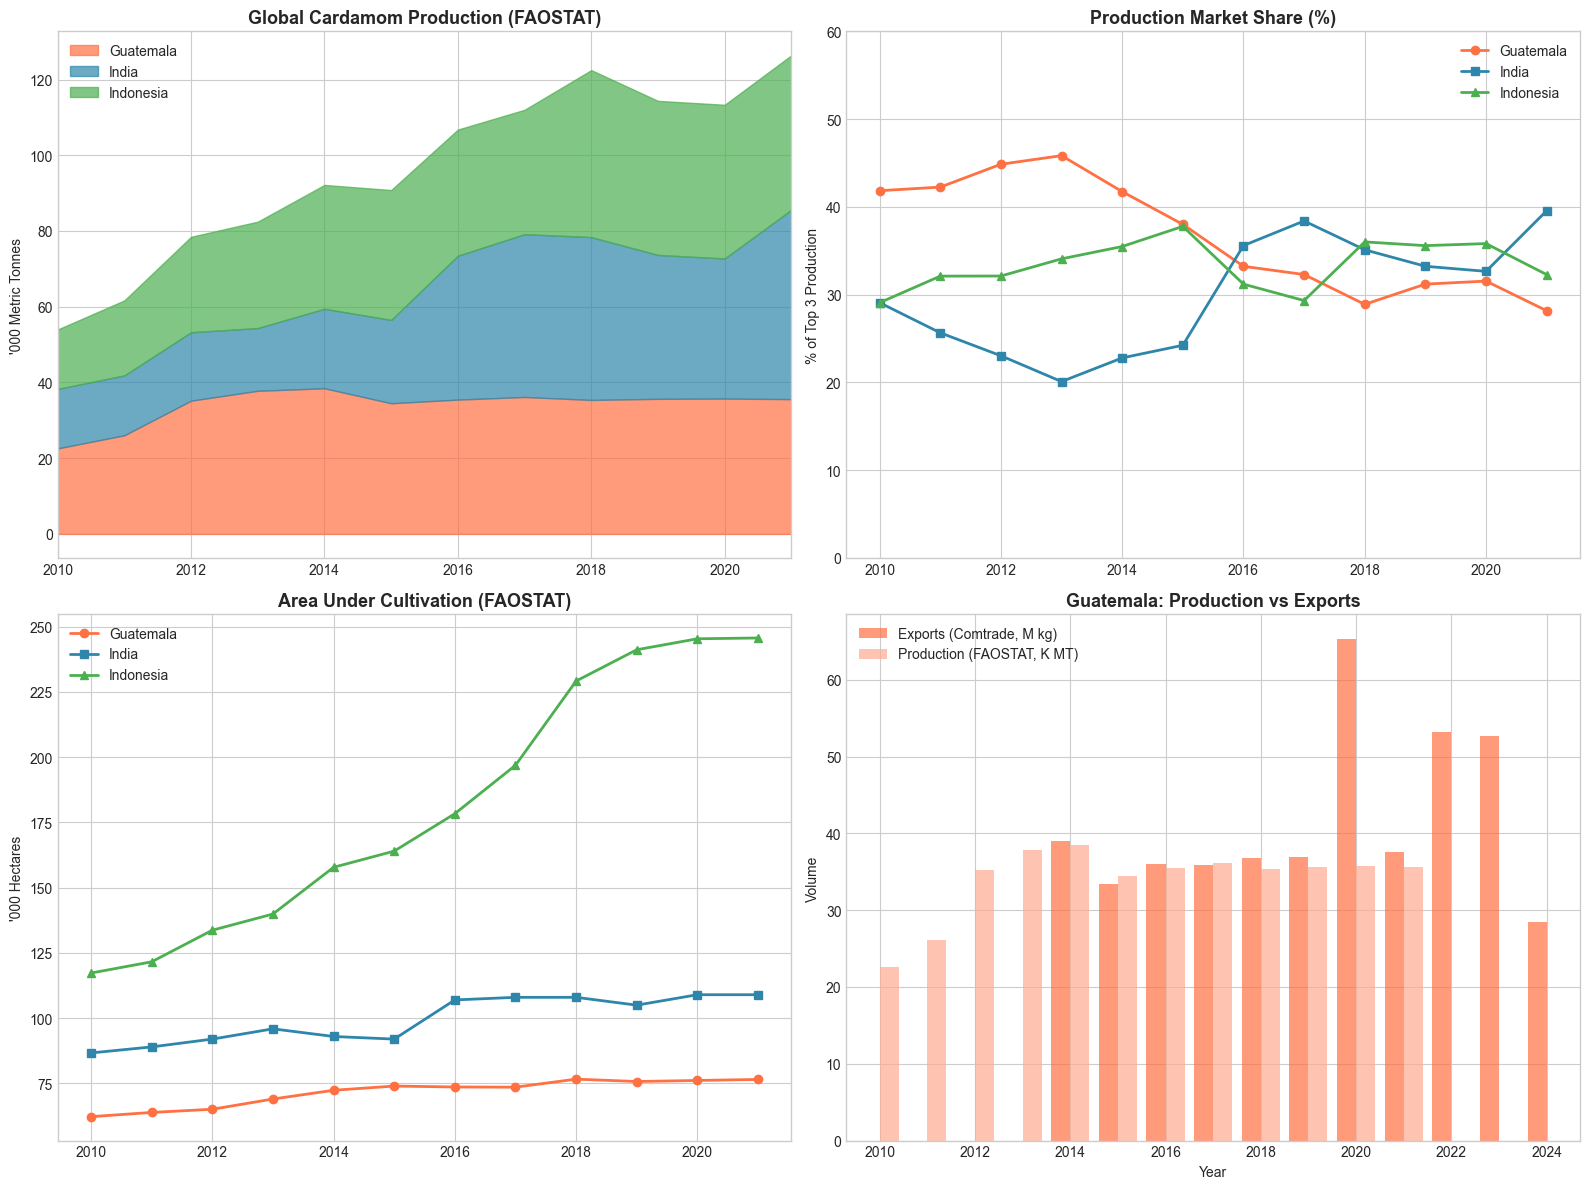

PRODUCTION vs EXPORT DATA COMPARISON

Note: FAOSTAT data for "Nutmeg, mace, cardamoms" goes to 2021 only.
Comtrade export data goes to 2024 and is more timely.

Guatemala exports by year (Comtrade):
  2014: Exported 39.1M kg ($241M, $6.2/kg) | FAOSTAT Production: 38.5K MT
  2015: Exported 33.4M kg ($243M, $7.3/kg) | FAOSTAT Production: 34.5K MT
  2016: Exported 35.9M kg ($230M, $6.4/kg) | FAOSTAT Production: 35.5K MT
  2017: Exported 35.8M kg ($367M, $10.2/kg) | FAOSTAT Production: 36.2K MT
  2018: Exported 36.8M kg ($434M, $11.8/kg) | FAOSTAT Production: 35.4K MT
  2019: Exported 36.9M kg ($650M, $17.6/kg) | FAOSTAT Production: 35.7K MT
  2020: Exported 65.3M kg ($1137M, $17.4/kg) | FAOSTAT Production: 35.7K MT
  2021: Exported 37.6M kg ($659M, $17.5/kg) | FAOSTAT Production: 35.6K MT
  2022: Exported 53.2M kg ($419M, $7.9/kg) | FAOSTAT Production: N/A
  2023: Exported 52.7M kg ($369M, $7.0/kg) | FAOSTAT Production: N/A
  2024: Exported 28.5M kg ($500M, $17.5/kg) | FAOSTAT Production:

In [16]:
# FAOSTAT production + area for top 3 producers
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Production (tonnes) stacked area
ax = axes[0, 0]
ax.fill_between(fao['Year'], 0, fao['Guatemala_Production_MT']/1000, alpha=0.7, color='#FF7043', label='Guatemala')
ax.fill_between(fao['Year'], fao['Guatemala_Production_MT']/1000, 
                (fao['Guatemala_Production_MT'] + fao['India_Production_MT'])/1000, alpha=0.7, color='#2E86AB', label='India')
ax.fill_between(fao['Year'], (fao['Guatemala_Production_MT'] + fao['India_Production_MT'])/1000,
                (fao['Guatemala_Production_MT'] + fao['India_Production_MT'] + fao['Indonesia_Production_MT'])/1000, 
                alpha=0.7, color='#4CAF50', label='Indonesia')
ax.set_title('Global Cardamom Production (FAOSTAT)', fontweight='bold', fontsize=13)
ax.set_ylabel("'000 Metric Tonnes")
ax.legend(fontsize=10)
ax.set_xlim(fao['Year'].min(), fao['Year'].max())

# 2. Market share
ax = axes[0, 1]
fao['total'] = fao['Guatemala_Production_MT'] + fao['India_Production_MT'] + fao['Indonesia_Production_MT']
ax.plot(fao['Year'], fao['Guatemala_Production_MT']/fao['total']*100, 'o-', color='#FF7043', linewidth=2, label='Guatemala')
ax.plot(fao['Year'], fao['India_Production_MT']/fao['total']*100, 's-', color='#2E86AB', linewidth=2, label='India')
ax.plot(fao['Year'], fao['Indonesia_Production_MT']/fao['total']*100, '^-', color='#4CAF50', linewidth=2, label='Indonesia')
ax.set_title('Production Market Share (%)', fontweight='bold', fontsize=13)
ax.set_ylabel('% of Top 3 Production')
ax.legend(fontsize=10)
ax.set_ylim(0, 60)

# 3. Area harvested
ax = axes[1, 0]
ax.plot(fao['Year'], fao['Guatemala_Area_Ha']/1000, 'o-', color='#FF7043', linewidth=2, label='Guatemala')
ax.plot(fao['Year'], fao['India_Area_Ha']/1000, 's-', color='#2E86AB', linewidth=2, label='India')
ax.plot(fao['Year'], fao['Indonesia_Area_Ha']/1000, '^-', color='#4CAF50', linewidth=2, label='Indonesia')
ax.set_title('Area Under Cultivation (FAOSTAT)', fontweight='bold', fontsize=13)
ax.set_ylabel("'000 Hectares")
ax.legend(fontsize=10)

# 4. Guatemala exports vs FAOSTAT production
ax = axes[1, 1]
# Annual Guatemala export from Comtrade
gt_annual_ct = ct_annual[ct_annual['source'] == 'Guatemala_Export']
gt_world = gt_annual_ct[gt_annual_ct['partner'] == 'World']
gt_world = gt_world.sort_values('period')
ax.bar(gt_world['period'] - 0.2, gt_world['netWgt_kg']/1e6, width=0.4, color='#FF7043', alpha=0.7, label='Exports (Comtrade, M kg)')
# FAOSTAT production
ax.bar(fao['Year'] + 0.2, fao['Guatemala_Production_MT']/1e3, width=0.4, color='#FFAB91', alpha=0.7, label='Production (FAOSTAT, K MT)')
ax.set_title('Guatemala: Production vs Exports', fontweight='bold', fontsize=13)
ax.set_ylabel('Volume')
ax.legend(fontsize=10)
ax.set_xlabel('Year')

plt.tight_layout()
plt.show()

# Key statistics
print('PRODUCTION vs EXPORT DATA COMPARISON')
print('='*80)
print()
print('Note: FAOSTAT data for "Nutmeg, mace, cardamoms" goes to 2021 only.')
print('Comtrade export data goes to 2024 and is more timely.')
print()
print('Guatemala exports by year (Comtrade):')
for _, r in gt_world.iterrows():
    yr = int(r['period'])
    val = (r['value_usd'] or 0) / 1e6
    qty = (r['netWgt_kg'] or 0) / 1e6
    unit = val / qty if qty > 0 else 0
    fao_prod = fao[fao['Year']==yr]['Guatemala_Production_MT'].values
    fao_str = f'{fao_prod[0]/1e3:.1f}K MT' if len(fao_prod) > 0 else 'N/A'
    print(f'  {yr}: Exported {qty:.1f}M kg (${val:.0f}M, ${unit:.1f}/kg) | FAOSTAT Production: {fao_str}')

### 8d. Guatemala Export Destinations — Where Does It All Go?

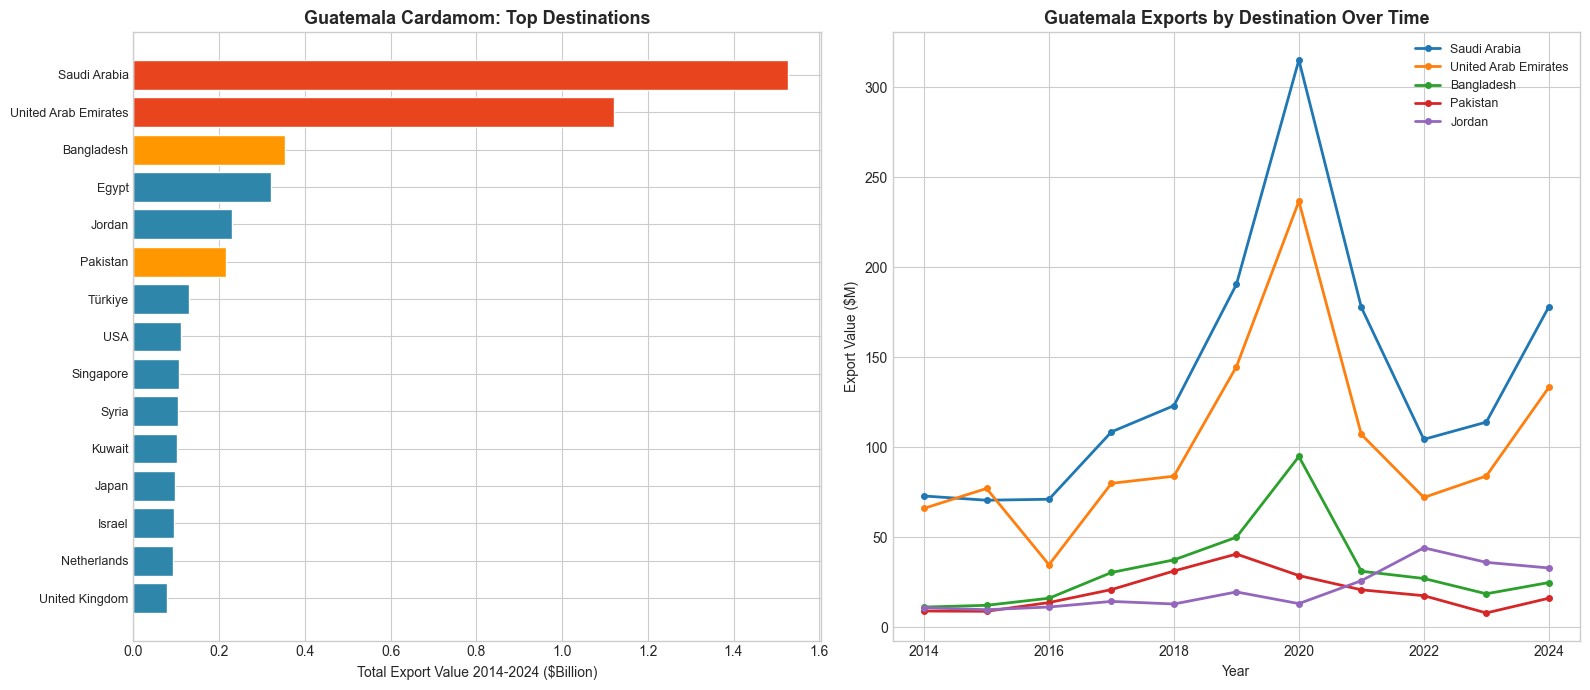

SAUDI ARABIA — Guatemala's Largest Customer
  2014: Saudi $73M of $241M total (30%)
  2015: Saudi $71M of $243M total (29%)
  2016: Saudi $71M of $230M total (31%)
  2017: Saudi $109M of $367M total (30%)
  2018: Saudi $123M of $434M total (28%)
  2019: Saudi $191M of $650M total (29%)
  2020: Saudi $315M of $1137M total (28%)
  2021: Saudi $178M of $659M total (27%)
  2022: Saudi $104M of $419M total (25%)
  2023: Saudi $114M of $369M total (31%)
  2024: Saudi $178M of $500M total (36%)


In [17]:
# Guatemala export destinations analysis
gt_dest = ct_annual[ct_annual['source'] == 'Guatemala_Export'].copy()
gt_dest = gt_dest[gt_dest['partner'] != 'World']

# Top destinations by total value across all years
top_dest = gt_dest.groupby('partner').agg(
    total_value=('value_usd', 'sum'),
    total_qty=('netWgt_kg', 'sum'),
    years=('period', 'nunique')
).sort_values('total_value', ascending=False).head(15)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# 1. Top 15 destinations by total value
ax = axes[0]
colors_dest = ['#E8451E' if 'Saudi' in d or 'United Arab' in d else '#FF9800' if 'Bangladesh' in d or 'Pakistan' in d 
               else '#2E86AB' for d in top_dest.index]
ax.barh(range(len(top_dest)), top_dest['total_value']/1e9, color=colors_dest, edgecolor='white')
ax.set_yticks(range(len(top_dest)))
ax.set_yticklabels(top_dest.index, fontsize=9)
ax.set_xlabel('Total Export Value 2014-2024 ($Billion)')
ax.set_title('Guatemala Cardamom: Top Destinations', fontweight='bold', fontsize=13)
ax.invert_yaxis()

# 2. Destination shift over time — Saudi vs others
ax = axes[1]
key_partners = ['Saudi Arabia', 'United Arab Emirates', 'Bangladesh', 'Pakistan', 'Jordan']
for partner in key_partners:
    sub = gt_dest[gt_dest['partner'] == partner].sort_values('period')
    if len(sub) > 2:
        ax.plot(sub['period'], sub['value_usd']/1e6, 'o-', linewidth=2, markersize=4, label=partner)
ax.set_title('Guatemala Exports by Destination Over Time', fontweight='bold', fontsize=13)
ax.set_ylabel('Export Value ($M)')
ax.set_xlabel('Year')
ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

# Saudi Arabia's share of Guatemala exports
print('SAUDI ARABIA — Guatemala\'s Largest Customer')
print('='*70)
gt_total_by_year = gt_dest.groupby('period')['value_usd'].sum()
sa_by_year = gt_dest[gt_dest['partner'] == 'Saudi Arabia'].set_index('period')['value_usd']
for yr in sorted(gt_total_by_year.index):
    total = gt_total_by_year.get(yr, 0) or 0
    sa = sa_by_year.get(yr, 0) or 0
    share = sa / total * 100 if total > 0 else 0
    print(f'  {yr}: Saudi ${sa/1e6:.0f}M of ${total/1e6:.0f}M total ({share:.0f}%)')

### 8e. The Big Picture — India Price vs Global Supply & Demand (All Data Combined)

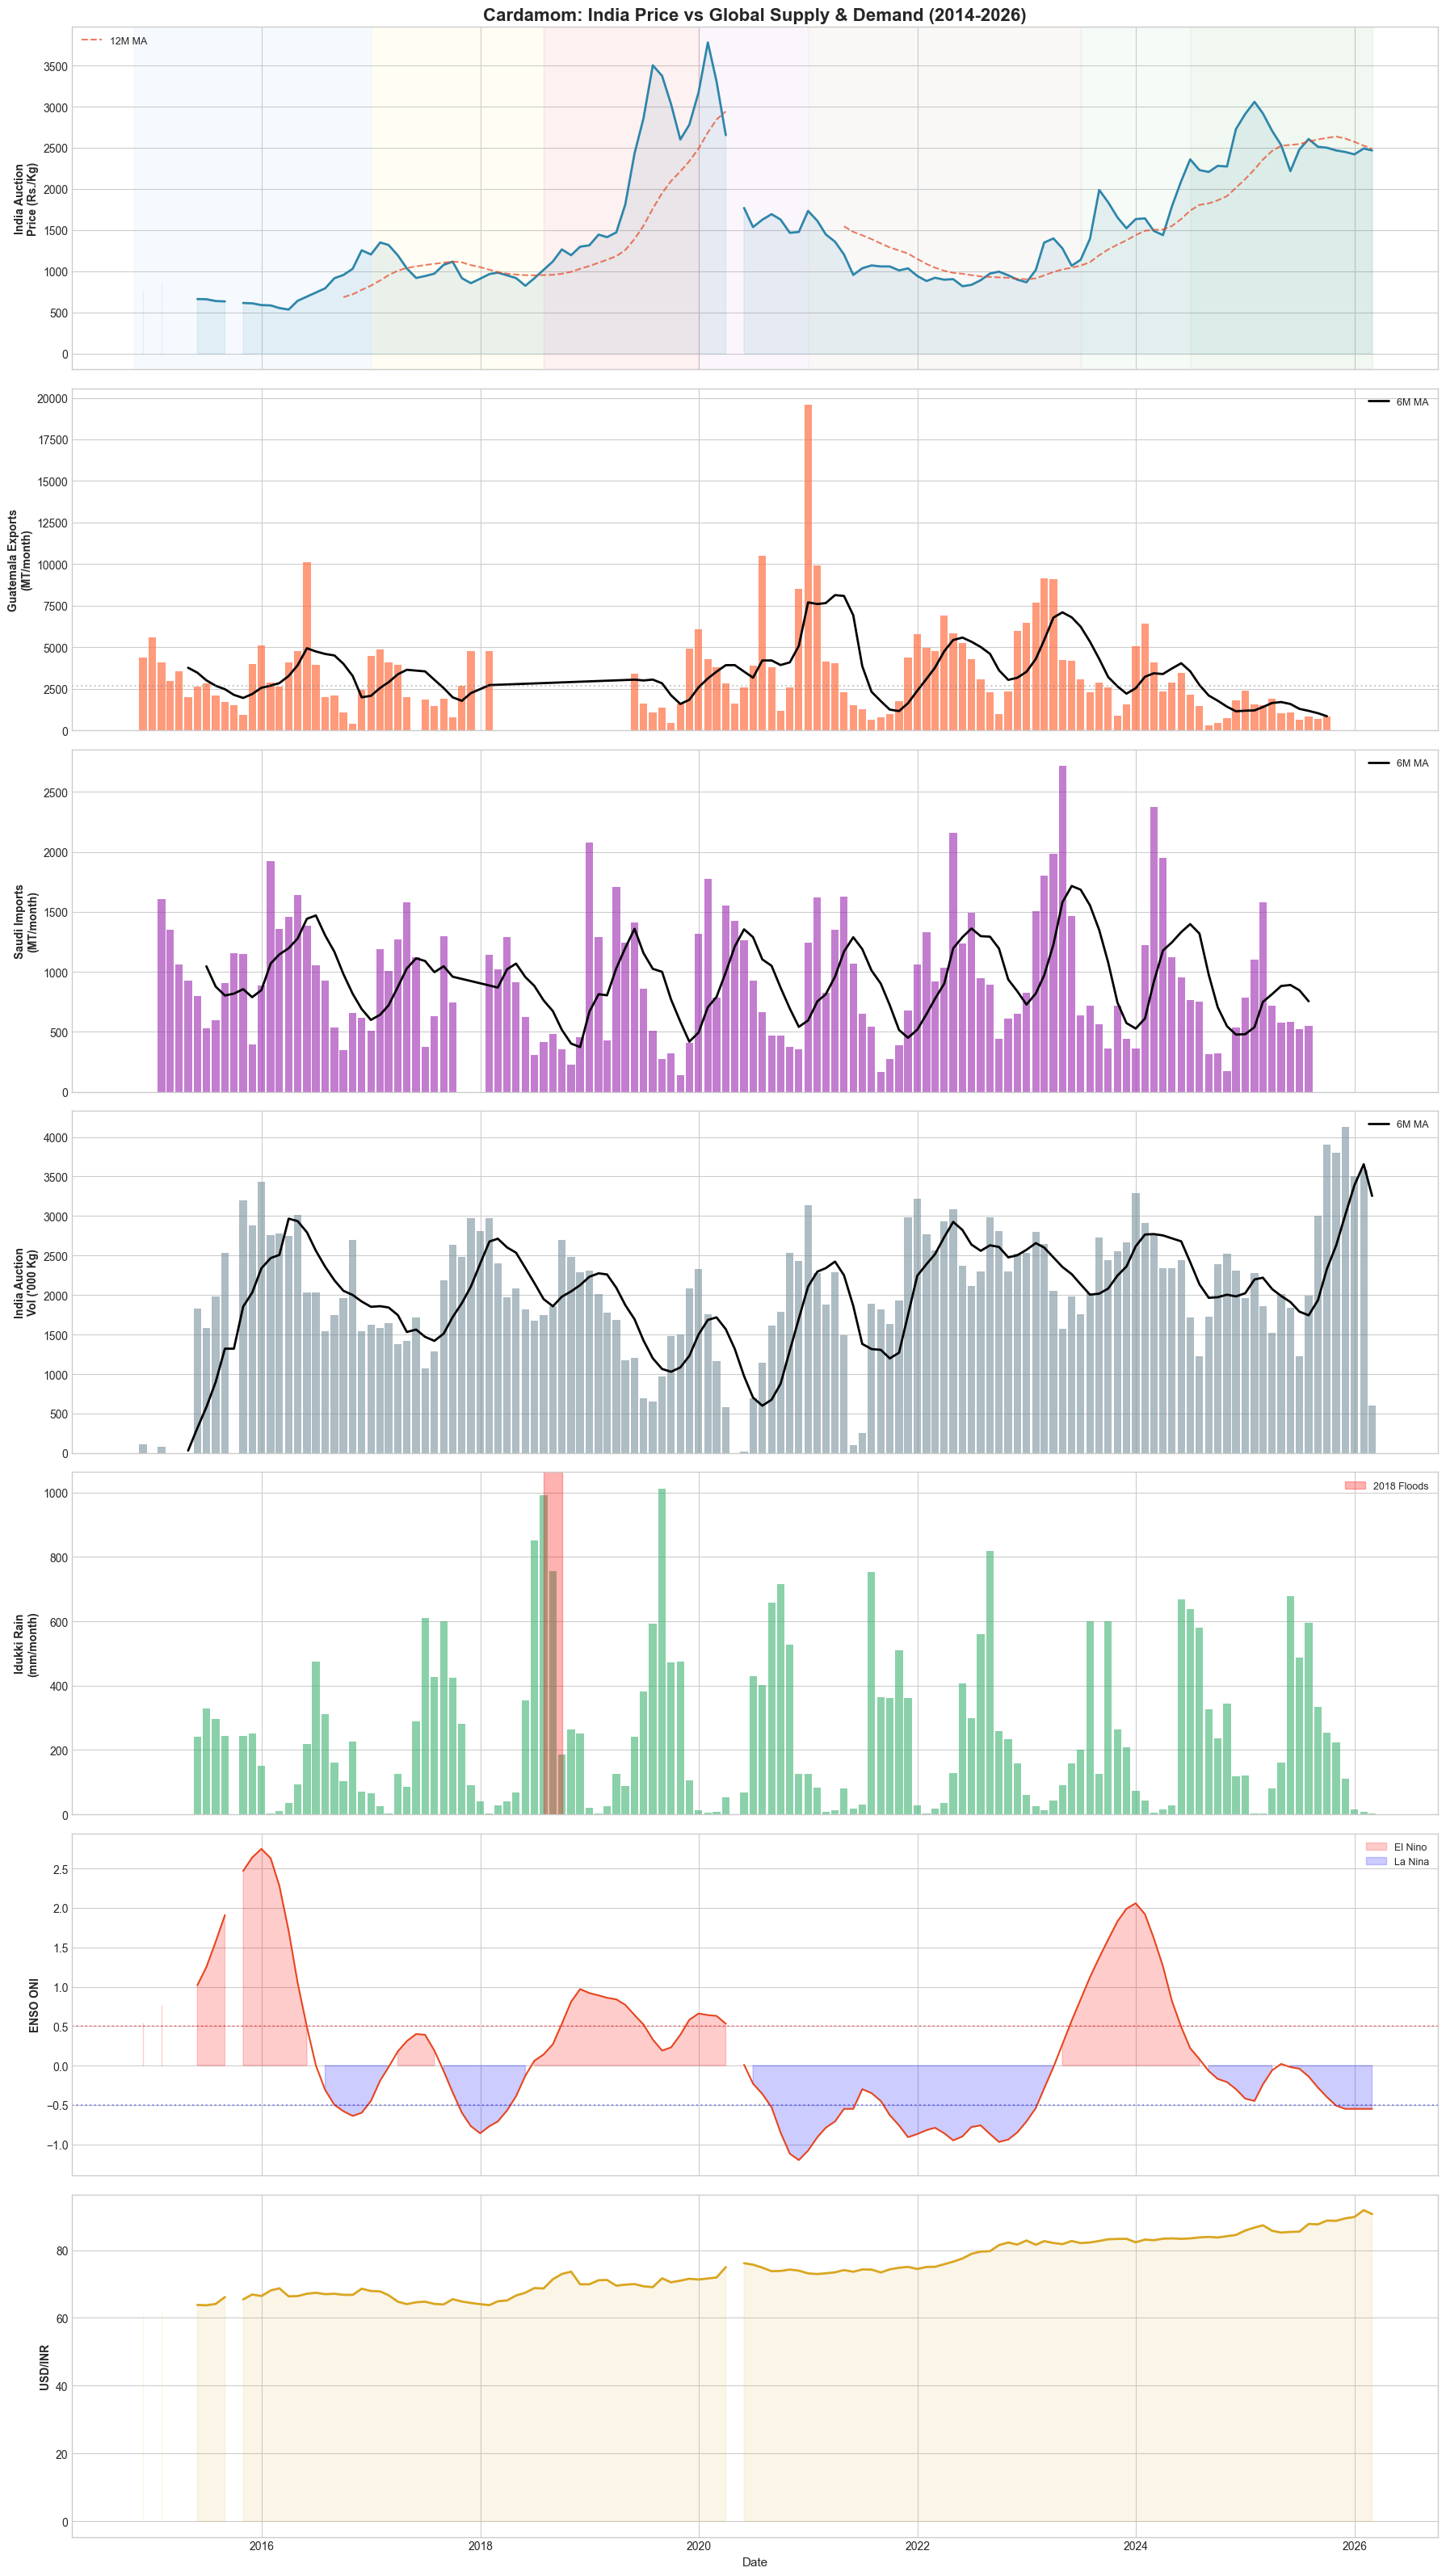

In [18]:
# THE MASTER CHART: 7-panel view with all data overlaid
fig, axes = plt.subplots(7, 1, figsize=(18, 32), sharex=True)

# Shared date range
date_min = pd.to_datetime('2014-11-01')
date_max = monthly_ext['Date'].max()

# === Panel 1: Indian Auction Price with regime shading ===
ax = axes[0]
ax.plot(monthly_ext['Date'], monthly_ext['AvgPrice'], color='#2E86AB', linewidth=2)
ax.plot(monthly_ext['Date'], monthly_ext['AvgPrice'].rolling(12).mean(), color='#E8451E', linewidth=1.5, alpha=0.7, linestyle='--', label='12M MA')
ax.fill_between(monthly_ext['Date'], monthly_ext['AvgPrice'], alpha=0.1, color='#2E86AB')
for start, end, label, color, _ in regimes:
    ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), alpha=0.08, color=color)
ax.set_ylabel('India Auction\nPrice (Rs./Kg)', fontsize=10, fontweight='bold')
ax.set_title('Cardamom: India Price vs Global Supply & Demand (2014-2026)', fontsize=16, fontweight='bold')
ax.legend(loc='upper left', fontsize=9)

# === Panel 2: Guatemala export volume (supply shock indicator) ===
ax = axes[1]
gt_sub = monthly_ext.dropna(subset=['gt_export_qty_mt'])
ax.bar(gt_sub['Date'], gt_sub['gt_export_qty_mt'], width=25, color='#FF7043', alpha=0.7)
gt_ma = gt_sub.set_index('Date')['gt_export_qty_mt'].rolling(6).mean()
ax.plot(gt_ma.index, gt_ma.values, color='black', linewidth=2, label='6M MA')
ax.set_ylabel('Guatemala Exports\n(MT/month)', fontsize=10, fontweight='bold')
ax.legend(fontsize=9)
# Shade high/low periods
ax.axhline(gt_sub['gt_export_qty_mt'].median(), color='gray', linestyle=':', alpha=0.4)

# === Panel 3: Saudi imports volume (demand signal) ===
ax = axes[2]
sa_sub = monthly_ext.dropna(subset=['sa_import_qty_mt'])
ax.bar(sa_sub['Date'], sa_sub['sa_import_qty_mt'], width=25, color='#9C27B0', alpha=0.6)
sa_ma = sa_sub.set_index('Date')['sa_import_qty_mt'].rolling(6).mean()
ax.plot(sa_ma.index, sa_ma.values, color='black', linewidth=2, label='6M MA')
ax.set_ylabel('Saudi Imports\n(MT/month)', fontsize=10, fontweight='bold')
ax.legend(fontsize=9)

# === Panel 4: Indian auction volumes ===
ax = axes[3]
ax.bar(monthly_ext['Date'], monthly_ext['Total_Sold']/1000, width=25, color='#78909C', alpha=0.6)
vol_ma = monthly_ext.set_index('Date')['Total_Sold'].rolling(6).mean() / 1000
ax.plot(vol_ma.index, vol_ma.values, color='black', linewidth=2, label='6M MA')
ax.set_ylabel('India Auction\nVol (\'000 Kg)', fontsize=10, fontweight='bold')
ax.legend(fontsize=9)

# === Panel 5: Idukki rainfall ===
ax = axes[4]
ax.bar(monthly_ext['Date'], monthly_ext['rain_mm'], width=25, color='#3CB371', alpha=0.6)
ax.axvspan('2018-08-01', '2018-09-30', alpha=0.3, color='red', label='2018 Floods')
ax.set_ylabel('Idukki Rain\n(mm/month)', fontsize=10, fontweight='bold')
ax.legend(fontsize=9)

# === Panel 6: ENSO ===
ax = axes[5]
ax.plot(monthly_ext['Date'], monthly_ext['ENSO'], color='#E8451E', linewidth=1.5)
ax.fill_between(monthly_ext['Date'], monthly_ext['ENSO'], 0, 
                where=monthly_ext['ENSO'] > 0, alpha=0.2, color='red', label='El Nino')
ax.fill_between(monthly_ext['Date'], monthly_ext['ENSO'], 0, 
                where=monthly_ext['ENSO'] < 0, alpha=0.2, color='blue', label='La Nina')
ax.axhline(0.5, color='red', linestyle=':', alpha=0.4)
ax.axhline(-0.5, color='blue', linestyle=':', alpha=0.4)
ax.set_ylabel('ENSO ONI', fontsize=10, fontweight='bold')
ax.legend(fontsize=9)

# === Panel 7: USD/INR ===
ax = axes[6]
ax.plot(monthly_ext['Date'], monthly_ext['USDINR'], color='#DAA520', linewidth=2)
ax.fill_between(monthly_ext['Date'], monthly_ext['USDINR'], alpha=0.1, color='#DAA520')
ax.set_ylabel('USD/INR', fontsize=10, fontweight='bold')
ax.set_xlabel('Date', fontsize=11)

plt.tight_layout()
plt.show()

## 9. Regime Narratives — Updated with Global Trade Evidence

In [19]:
# Updated regime narratives with Comtrade/FAOSTAT evidence

def get_period_stats(df, start, end, col):
    """Get mean of a column in a date range"""
    mask = (df['Date'] >= start) & (df['Date'] <= end)
    vals = df.loc[mask, col].dropna()
    return vals.mean() if len(vals) > 0 else None

print('='*90)
print('REGIME NARRATIVES — UPDATED WITH GLOBAL TRADE DATA')
print('='*90)

narratives = [
    {
        'name': 'STABLE LOW (2014-2016)',
        'dates': ('2014-11-01', '2016-12-31'),
        'evidence': [
            ('Guatemala exports', 'Steady at 33-39K MT/year ($230-243M). No supply disruption.'),
            ('Saudi imports', 'Stable ~$110-126M/year. Demand unremarkable.'),
            ('FAOSTAT', 'Guatemala production stable ~35K MT. India ~21-22K MT. Global supply adequate.'),
            ('Indian auctions', 'Volume steady. Sell-through ~95-97%. No urgency.'),
            ('ENSO', 'Strong El Nino 2015-16 (ONI +1.8) but didn\'t trigger India supply shock.'),
            ('USD/INR', 'Stable at Rs.64-67. No export competitiveness shift.'),
        ]
    },
    {
        'name': 'FLOOD SPIKE & ALL-TIME HIGH (2018-2019)',
        'dates': ('2018-08-01', '2019-12-31'),
        'evidence': [
            ('Guatemala exports', '2019: $650M (record), but volume flat at 37K MT. Price-driven, not supply surge.'),
            ('Guatemala price', 'Guatemala export price also surged — confirming global supply shortage, not India-specific.'),
            ('Saudi imports', '2019: $188M, up from $141M in 2018. Saudi paying more for same volume (~10K MT).'),
            ('Indian auctions', 'Volume crashed — only 17.5K MT sold in 2019 (vs 26K in 2018). Supply destruction.'),
            ('Idukki rain', '2018 floods: 3,812mm annual. 2019 also heavy: 3,540mm. Back-to-back damage.'),
            ('ENSO', 'Transitioning El Nino 2018-19 (ONI +0.58). Disrupted Guatemala too.'),
        ]
    },
    {
        'name': 'COVID CRASH & OVERSUPPLY (2020-2023)',
        'dates': ('2020-01-01', '2023-06-30'),
        'evidence': [
            ('Guatemala exports', '2020: MASSIVE SURGE to 65K MT ($1.14B!) — nearly double normal. Speculative?'),
            ('', '2022-23: Still high at 52-53K MT. Guatemala flooding the market.'),
            ('Saudi imports', '2020: $319M (COVID stockpiling?). Then declined to $140M by 2023 as prices normalized.'),
            ('FAOSTAT production', 'India ramped to 50K MT by 2021 (up from 38K in 2019). India + Guatemala both expanded.'),
            ('Indian auctions', 'Volume surged to 31K MT by 2022 (vs 17K in 2019). Supply glut confirmed.'),
            ('ENSO', 'Triple-dip La Nina 2020-2023 (ONI down to -0.85). Good monsoons = bumper harvests.'),
            ('USD/INR', 'Rupee weakening (Rs.73 to Rs.83) partially offset price decline for exporters.'),
        ]
    },
    {
        'name': 'CURRENT BULL RUN (2024-2026)',
        'dates': ('2024-07-01', '2026-02-28'),
        'evidence': [
            ('Guatemala exports', '2024: COLLAPSED to 28.5K MT (down 46%!). Thrips pest damage per CARDEGUA.'),
            ('', '2025 (Jan-Sep): Only 10.2M kg. Annualizing to ~13.6K MT — a 75% collapse from 2023.'),
            ('Saudi imports', '2024: $251M (up 79% from $140M in 2023). Demand surging, supply tight.'),
            ('', '2025 (Jan-Jul): $174M, annualizing to ~$298M. Saudi paying record prices.'),
            ('Indian auctions', 'India now the dominant supplier as Guatemala supply fails.'),
            ('', 'Sell-through back to 97% — market absorbing everything.'),
            ('ENSO', 'El Nino 2023-24 (ONI +0.81) weakened monsoon. Now shifting La Nina (-0.55).'),
            ('USD/INR', 'Rs.87-91. Weakest rupee ever = strongest export incentive ever.'),
            ('THE KEY INSIGHT', 'This rally is NOT just India-driven. Guatemala\'s supply shock is the '),
            ('', 'primary GLOBAL catalyst. The thrips damage + reduced planting = tight supply worldwide.'),
        ]
    }
]

for n in narratives:
    print(f'\n{"="*90}')
    print(f'  {n["name"]}')
    
    # Get India price range
    mask = (monthly_ext['Date'] >= n['dates'][0]) & (monthly_ext['Date'] <= n['dates'][1])
    sub = monthly_ext[mask]
    if len(sub) > 0:
        print(f'  India Price: Rs.{sub["AvgPrice"].min():.0f} - Rs.{sub["AvgPrice"].max():.0f} (avg Rs.{sub["AvgPrice"].mean():.0f})')
    print(f'{"="*90}')
    
    for label, detail in n['evidence']:
        if label:
            print(f'  [{label}]')
        print(f'    {detail}')

REGIME NARRATIVES — UPDATED WITH GLOBAL TRADE DATA

  STABLE LOW (2014-2016)
  India Price: Rs.536 - Rs.1256 (avg Rs.760)
  [Guatemala exports]
    Steady at 33-39K MT/year ($230-243M). No supply disruption.
  [Saudi imports]
    Stable ~$110-126M/year. Demand unremarkable.
  [FAOSTAT]
    Guatemala production stable ~35K MT. India ~21-22K MT. Global supply adequate.
  [Indian auctions]
    Volume steady. Sell-through ~95-97%. No urgency.
  [ENSO]
    Strong El Nino 2015-16 (ONI +1.8) but didn't trigger India supply shock.
  [USD/INR]
    Stable at Rs.64-67. No export competitiveness shift.

  FLOOD SPIKE & ALL-TIME HIGH (2018-2019)
  India Price: Rs.1120 - Rs.3502 (avg Rs.2123)
  [Guatemala exports]
    2019: $650M (record), but volume flat at 37K MT. Price-driven, not supply surge.
  [Guatemala price]
    Guatemala export price also surged — confirming global supply shortage, not India-specific.
  [Saudi imports]
    2019: $188M, up from $141M in 2018. Saudi paying more for same volu

## 10. Updated Takeaways — What the Global Data Changes

### Revised Regime Change Drivers (re-ranked with trade data)

1. **Guatemala Supply Shocks** (NEW #1) — Guatemala is 50%+ of global cardamom exports. When Guatemala's supply collapses (thrips 2024, weather 2019), global prices surge regardless of Indian production. The 2024-26 rally is primarily a Guatemala story.

2. **Weather / ENSO** — Still critical, but now understood as affecting BOTH India AND Guatemala simultaneously. El Nino disrupts both origins. La Nina helps both.

3. **Indian Supply (Kerala floods, planting cycle)** — Important for Indian auction prices but NOT the dominant global force. India is ~30% of production vs Guatemala's ~40%.

4. **Saudi/Middle East Demand** — Remarkably stable in VOLUME (9-13K MT/year from Saudi alone). What changes is PRICE. Saudi is a price-taker, not a demand driver. Demand is inelastic.

5. **Currency (USD/INR)** — Secular tailwind. Rs.61 in 2014 to Rs.91 in 2026. Makes Indian exports steadily more competitive but doesn't cause regime changes.

6. **COVID/Black Swans** — One-time events that accelerate existing trends rather than creating new ones.

### The Guatemala Anomaly: 2020 vs 2024

| Year | Guatemala Exports | India Auction Price | What Happened |
|------|------------------|---------------------|---------------|
| 2020 | **65K MT** (surge) | Rs.2,085 (falling) | Guatemala flooded market, India prices crashed |
| 2024 | **28.5K MT** (collapse) | Rs.2,122 (rising) | Guatemala supply failed, India prices surged |
| 2025 | **~14K MT** (annualized) | Rs.2,570 (peak) | Guatemala crisis deepens, India prices at 7-year highs |

**This is the clearest evidence that Guatemala supply is the primary price driver.**

### Implications for Forecasting

- Any model without Guatemala export data is missing the #1 driver of price regimes
- Saudi import data provides real-time demand confirmation (useful but not causal)
- Guatemala's thrips recovery timeline is the most important variable for the next regime change
- When Guatemala exports recover to 35K+ MT/year, expect bearish pressure on Indian prices